# Developing My Own Stock Trading Strategy (Data Mining, Algorithm Design, and Optimization with GAs)

People have been trying to come up with tips, tricks, formulas, and algorithms for trading for as long as markets have existed. The development of new market sectors, the rise of online trading, and the overall increase in *data* have led to trillions of dollars exchanging hands between automated systems. Most of this is done by investment firms with incredibly complicated, highly tuned models, and fancy techniques such as high frequency trading and statistical arbitrage. As someone with a moderate amount of data analysis and ML experience (and an unreasonable amount of self confidence) I want to see how hard it could be!

**Disclaimer**: None of this is financial advice. We will also make a few approximations that help simplify the market conditions, but lead to a simulation that is not very faithful to reality. See the caveats section at the end.

## Data Collection

The first step in any sort of data analysis is of course getting the data. There's a lot of stock data out there, more than I can fit on a single hard drive. I'm going to focus on the S&P 500, which is an electronically traded fund (ETF) of 500 of the best performing publicly trading companies in the United States. This is a commonly traded fund has high volume and a good reputation due to its impressive historical performance, so it's a good place to start. In particular we want minute by minute data, as fine grained as we can get. 

The Alpha Vantage website is a good choice (https://www.alphavantage.co/) because it's free and has a simple API. The downside is that it has a maximum of 6 requests per minute, 100 requests per day, and will only send 1 month of data at a time, so we have to play some games to patch together all the data we want. We'll request extended hours data just so that we can get values for the price at 16:00:00 (5:00 PM) EST.

(If you'd like to follow along, you may need to make a couple different API keys and change your IP address, *or you can just skip this part and ust the data I've already collected*)

In [96]:
import re
import os
import json
import copy
import random
import requests

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fancybox'] = True

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

from IPython import display

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
with open('secrets.json', 'r') as secrets_file:
    secrets = json.load(secrets_file)

# Define the API endpoint and parameters
endpoint = 'https://www.alphavantage.co/query'
params = {
    'function': 'TIME_SERIES_INTRADAY',
    'symbol': 'SPY',
    'interval': '1min',
    'apikey': secrets["alphavantage_apikey"],
    'extended_hours': 'true',
    'outputsize': 'full',
    'month': '2023-07'
}

# Initialize an empty DataFrame to store the data
full_df = pd.DataFrame()

# Define the date range for data retrieval
start_date = datetime(2016, 7, 1)
end_date = datetime(2023, 7, 31)

counter = 0
# Loop through each month within the date range
current_date = start_date
while current_date <= end_date:
    month = current_date.strftime('%Y-%m')
    params['month'] = month

    print("Requesting data for", month)
    
    # Make the API request
    response = requests.get(endpoint, params=params)
    data = response.json()
    
    # Extract the time series data from the response
    time_series = data.get('Time Series (1min)')
    
    if time_series:
        counter = 0

        # Convert the data to a pandas DataFrame
        df = pd.DataFrame.from_dict(time_series, orient='index')
        df.index = pd.to_datetime(df.index)
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        
        # Filter data between market hours (9:30 AM to 4:00 PM)
        df = df.between_time('09:30:00', '16:00:00')
        
        # Append the current month's data to the full DataFrame
        full_df = pd.concat([full_df, df])
    
        # Move to the next month
        current_date = current_date.replace(day=1) + pd.DateOffset(months=1)
    
    else:
        counter += 1
        print("API request failed, waiting and retrying")
        time.sleep(40) # Maximum API requests per min have been reached

        if counter >= 3:
            print("Used maximum number of API requests for today")
            break

# Sort the full DataFrame by index (date)
full_df.sort_index(inplace=True)

# Save the full DataFrame to a CSV file
full_df.to_csv('full_data_07-2016_to_06-2023.csv')

## Data Processing, Transformation, and Exploration

Through perfectly ethical means I've managed to get two .csv files that together have minute by minute data for every trading day from August 2010 to August 2023. Now I can shove them together into a single, giant pandas dataframe. Fun fact, did you know that Excel has limit of roughly 1 million rows and 20K columns? It seems like more than enough and it usually is ... until it's not.

In [2]:
market_df_2010to2016 = pd.read_csv("full_data_07-2010_to_06-2016.csv", index_col=0, parse_dates=True)
market_df_2016to2023 = pd.read_csv("full_data_07-2016_to_07-2023.csv", index_col=0, parse_dates=True)
market_df = pd.concat([market_df_2010to2016, market_df_2016to2023])

display.display((market_df.head()))

open    high     low   close   volume
2010-07-01 09:30:00  80.639  80.754  80.393  80.502  1661899
2010-07-01 09:31:00  80.585  80.668  80.362  80.485   797772
2010-07-01 09:32:00  80.569  80.653  80.308  80.454  1114100
2010-07-01 09:33:00  80.538  80.739  80.370  80.571  1464468
2010-07-01 09:34:00  80.655  80.754  80.425  80.524  1032889

Each minute row has an **open**,  **high**,  **low**,  **close**, and **volume** column. This is a way of representing how the price moves within a particular time frame (1 minute chunks in this case). The **open** (**close**) is the price at the beginning (end) of the minute, the **high** (**low**) is the highest (lowest) price reached within that minute, and the volume is the number of individual units traded during that minute. We can see that the volume is indeed high, with 1 million or so units traded per minute, and roughly 400 million dollars of value traded within the first 5 minutes of the day. 

These values are good for getting a detailed picture, but if we want to visualize the value of the stock in a particular day we need to do some sort of averaging to get a single value for the minute. Yes, I know about candle charts, but that's more complicated than is necessary right now. A resonable choice is to take the average the open and close values. We will also break off days into individual dataframes to make the entire data set easier to manage.

(Note this may take 5 to 10 minutes to run, or you can just load the pickle object)

In [ ]:
# Calculate the average of open and close for each minute, 
# round to 3 decimals to be consistent with the other price values
market_df["average"] = round((market_df["open"] + market_df["close"]) / 2, 3)

# Get a list of unique dates in the DataFrame
trading_days = []
for date in market_df.index.date:
    if date not in trading_days:
        trading_days.append(date)

# Sort dataframe into trading days
market_by_days = [market_df[market_df.index.date == date] for date in trading_days]

In [3]:
import pickle
with open('market_by_days.pkl', 'rb') as f:
    market_by_days = pickle.load(f)

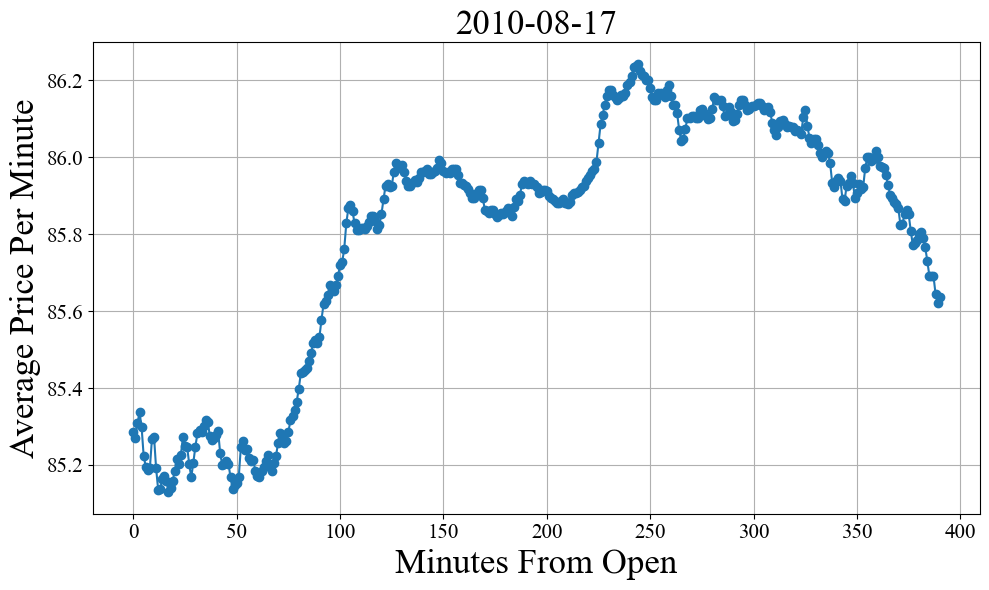

In [4]:
day = market_by_days[32]
minutes_from_open = ((day.index - day.index[0]).total_seconds().astype(int) // 60).tolist()
plt.figure(figsize=(10, 6))

plt.plot(minutes_from_open, day['average'], marker='o', linestyle='-')
plt.xlabel('Minutes From Open', fontsize=25)
plt.ylabel('Average Price Per Minute', fontsize=25)
plt.title(str(day.index[0].date()), fontsize=25)

plt.tight_layout()
plt.show()

We have liftoff! Note that because the market opens at 9:30:00 AM EST and closes at 16:00:00 PM EST, this corresponds to 6 and a half hours or 390 total minutes of trading time per day. Now it's time to start looking for trends that can be exploited. One of the simplest things we can try to ask if certain times of day more correlated with a particular increase or decrease? Do people tend to sell a lot more right at the end of the day so that they can avoid any big overnight market moves? Is there a jump in action around 10:00 AM to 11:00 AM when the west coast wakes up?

To test this, the code block belowloops over every day in our `market_by_days` list (in 10 minute chunks) and looks at the percentage point change (PPC) from some start time to some stop time. PPC is defined as (end price - start price) / (start price), so if the ETF starts the day at $100 and ends the day at $110 dollars, that's a PPC of 10%.

In [55]:
import datetime

def x_min_trend(df, x_min_start, x_min_stop):
    """ returns the percentage point change from x_min_start to x_min_stop """
    temp = df.between_time(x_min_start, x_min_stop, inclusive="both")["average"].values.tolist()
    return (temp[-1] - temp[0]) / temp[0] * 100 # percent point change

start_time = datetime.time(9, 30, 0)
end_time = datetime.time(16, 0, 0)
time_interval = datetime.timedelta(minutes=10)

times = [] # List of datetime.time objects, spaced 10 minutes apart
current_datetime = datetime.datetime.combine(datetime.datetime.today(), start_time)
while current_datetime.time() <= end_time:
    times.append(current_datetime.time())
    current_datetime += time_interval

returns_arr = [] # row is start time, column is end time
for start_time in times:
    row = []
    for end_time in times:
        if start_time < end_time:
            returns_temp = []
            for df in market_by_days:
                try:
                    returns_temp.append(x_min_trend(df, x_min_start=start_time, x_min_stop=end_time))
                except:
                    pass # For some reason, no data for this minute
            row.append(round(np.asarray(returns_temp).mean(), 5))
        else:
            row.append(np.NaN)
    returns_arr.append(row)

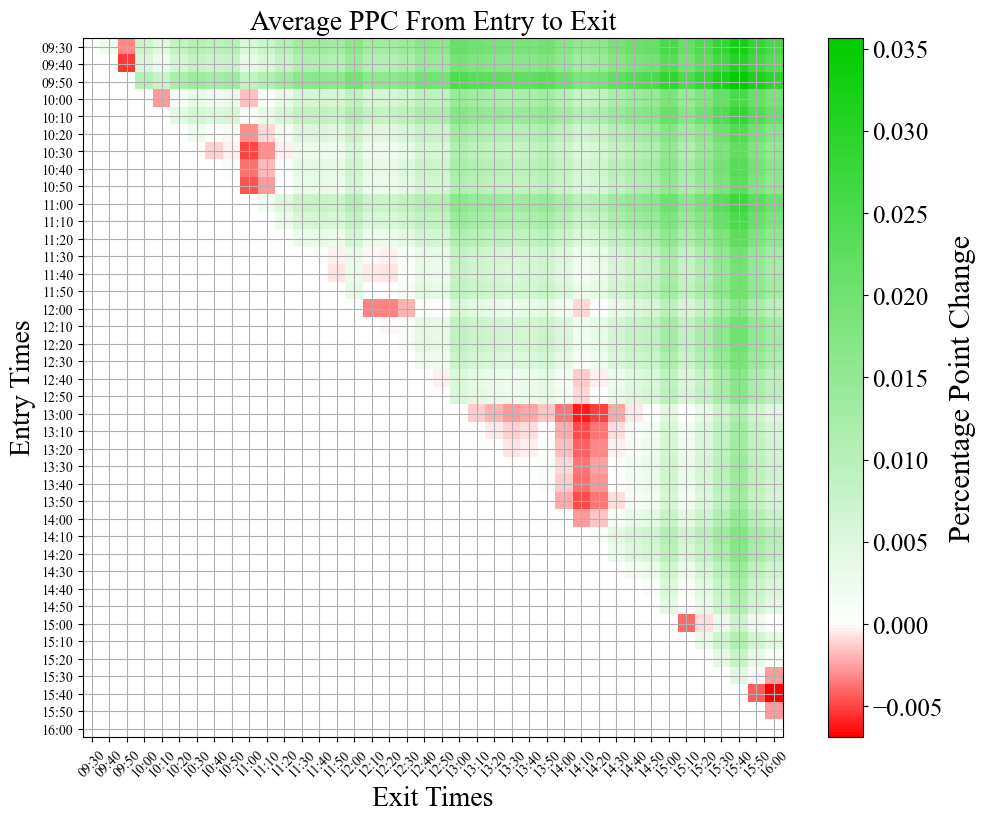

In [63]:
from matplotlib.colors import LinearSegmentedColormap

# Colors for the colormap
colors = [(1.0, 0.0, 0.0), (1.0, 1.0, 1.0), (0.0, 0.8, 0.0)]  # Red, White, Green

vmax = np.max(np.asarray(returns_arr)[~np.isnan(np.asarray(returns_arr))])
vmin = np.min(np.asarray(returns_arr)[~np.isnan(np.asarray(returns_arr))])

values = [vmin, 0.0, vmax]
norm = plt.Normalize(min(values), max(values))

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm(values), colors)))

plt.figure(figsize=(10, 8))
plt.imshow(returns_arr, cmap = custom_cmap, interpolation = 'nearest')

plt.title("Average PPC From Entry to Exit", fontsize=20)
cbar = plt.colorbar()
cbar.set_label('Percentage Point Change', fontsize=22)
cbar.ax.tick_params(labelsize=18)

plt.xticks(range(len(times)), [t.strftime('%H:%M') for t in times], rotation=45, fontsize=10)
plt.yticks(range(len(times)), [t.strftime('%H:%M') for t in times], fontsize=10)

plt.tight_layout()
plt.ylabel('Entry Times', fontsize=20)
plt.xlabel('Exit Times', fontsize=20)
plt.show()

This shows us multiple interesting trends!
1) The average PPC is overwhelmingly positive. This makes a decent amount of sense, as it's well known that the S&P 500 tends to move upwards over time.
2) On average, the best buy time, sell time combo is buying at the beginning of the day (09:30) and selling just before the end of the day (15:40). Another feather in the cap of the buy and hold strategy.
3) On average the worst buy time, sell time combo is buying right at 15:40 and selling at 16:00. This supports our original hypothesis that there is (on average) a general selloff right before the markets close. This is most likely because overnight the price of a stock or ETF can change dramatically in response to events, making it potentially risky to hold an asset overnight.
4) There is also a pretty large red cloud on the 13:00 to 14:00 time frame, but I don't have any strong intuition as to why this could be, other than people coming back from lunch.
5) The times that are more significant to us as a society (hour and half hour marks) can be seen identified by the slight checkerboard pattern that their lines make across the plot. This just goes to show how psychology can be a big part of how the market moves.

At the end of the day though, these are all pretty small PPCs. The maximum avg value we see is 0.03%, which annualized over a year comes in a just under 10% annual returns (accounting for only 252 trading days per year). It's possible that this edge could be exploited by a model which uses the statistical behavior to its advantage, but that kind of near future price direction predicition is difficult at best, and the edge is not that strong. I'd much rather go for something with much more upside. Let's try looking at the average *absolute* PPC to see where the most dramatic price swings are.

In [136]:
import datetime

start_time = datetime.time(9, 30, 0)
end_time = datetime.time(16, 0, 0)
time_interval = datetime.timedelta(minutes=10)

times = [] # List of datetime.time objects, spaced 10 minutes apart
current_datetime = datetime.datetime.combine(datetime.datetime.today(), start_time)
while current_datetime.time() <= end_time:
    times.append(current_datetime.time())
    current_datetime += time_interval

abs_returns_arr = [] # row is start time, column is end time
for start_time in times:
    row = []
    for end_time in times:
        if start_time < end_time:
            returns_temp = []
            for df in market_by_days:
                try:
                    returns_temp.append(x_min_trend(df, x_min_start=start_time, x_min_stop=end_time))
                except:
                    pass # For some reason, no data for this minute
            absolute_ppc = round(np.abs(np.asarray(returns_temp)).mean(), 5)
            row.append(absolute_ppc) 
        else:
            row.append(np.NaN)
    abs_returns_arr.append(row)

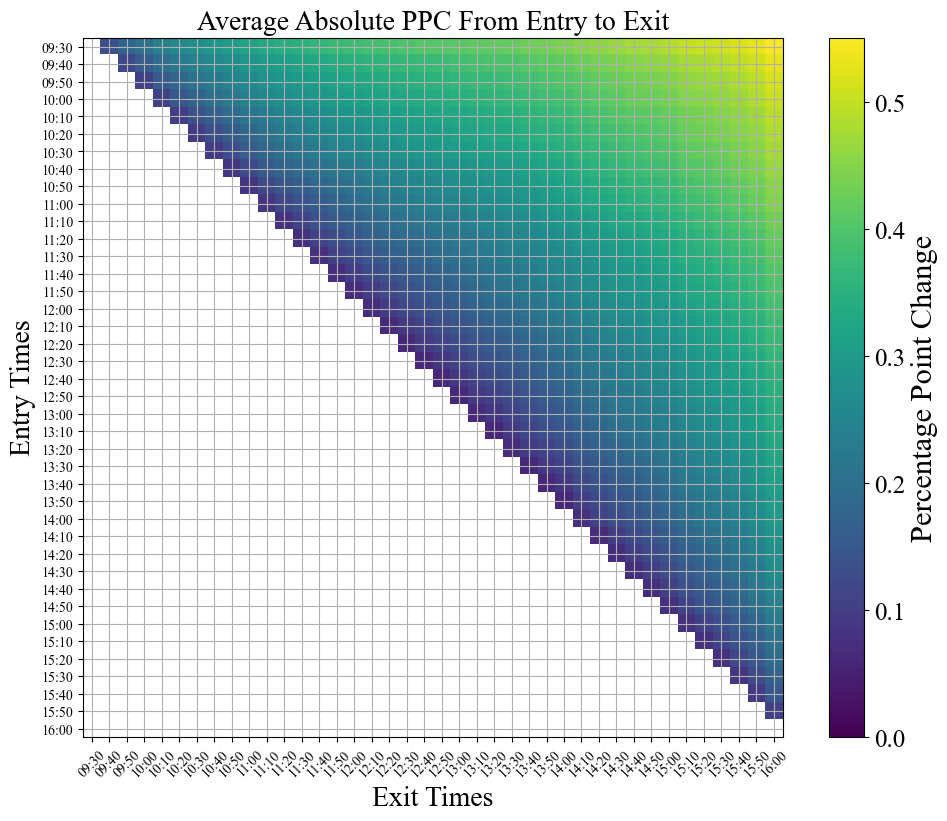

In [137]:
plt.figure(figsize=(10, 8))
plt.imshow(abs_returns_arr, cmap='viridis', interpolation = 'nearest', vmin=0)

plt.title("Average Absolute PPC From Entry to Exit", fontsize=20)
cbar = plt.colorbar()
cbar.set_label('Percentage Point Change', fontsize=22)
cbar.ax.tick_params(labelsize=18)

plt.xticks(range(len(times)), [t.strftime('%H:%M') for t in times], rotation=45, fontsize=10)
plt.yticks(range(len(times)), [t.strftime('%H:%M') for t in times], fontsize=10)

plt.tight_layout()
plt.ylabel('Entry Times', fontsize=20)
plt.xlabel('Exit Times', fontsize=20)
plt.show()

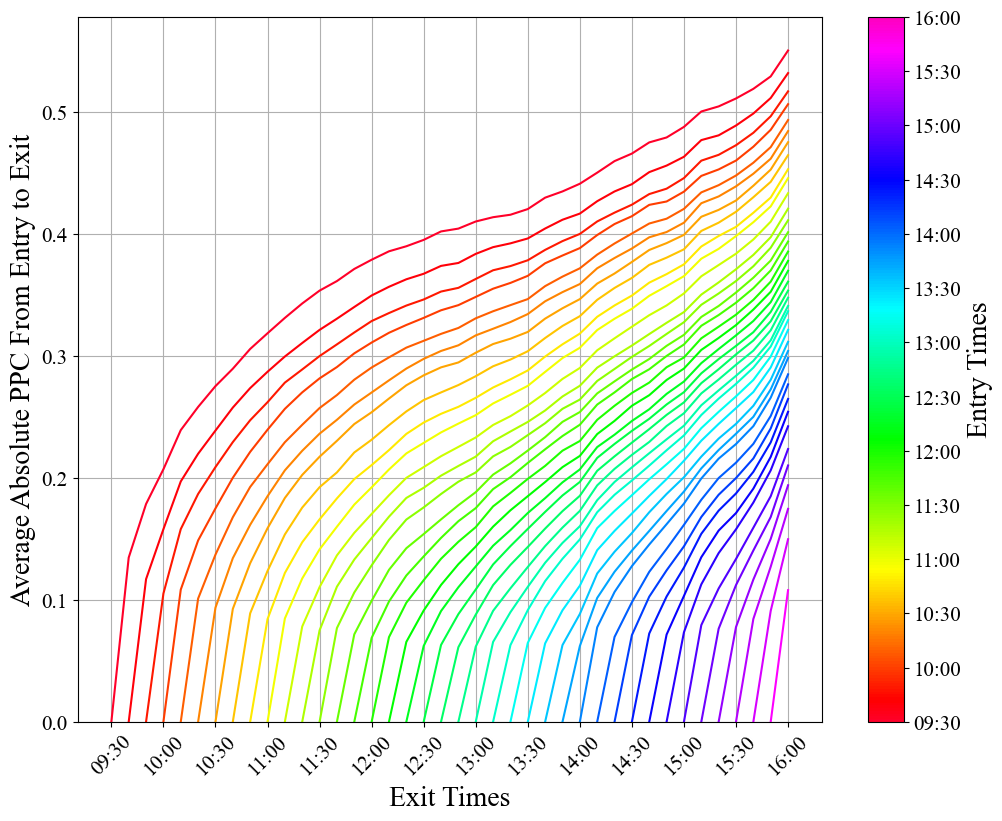

In [138]:
plt.figure(figsize=(10, 8))

cmap = plt.get_cmap('gist_rainbow')

x = np.arange(0,len(times),1)
for i, row in enumerate(abs_returns_arr):
    last_nan_index = row[::-1].index(np.nan)
    last_nan_index = len(row) - last_nan_index - 1
    row[last_nan_index] = 0
    color = cmap(i / len(abs_returns_arr))
    plt.plot(x, row, color=color)

plt.xticks(np.arange(0, len(times), 3), [t.strftime('%H:%M') for i, t in enumerate(times) if i % 3 == 0], rotation=45)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(abs_returns_arr) - 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), ticks=np.arange(0, len(times), 3))
cbar.set_label('Entry Times', fontsize=20)
cbar.set_ticklabels([t.strftime('%H:%M') for i, t in enumerate(times) if i % 3 == 0])

plt.ylim(0, None)

plt.tight_layout()
plt.ylabel('Average Absolute PPC From Entry to Exit', fontsize=20)
plt.xlabel('Exit Times', fontsize=20)
plt.show()

In [139]:
import datetime

start_time = datetime.time(9, 30, 0)
end_time = datetime.time(16, 0, 0)
time_interval = datetime.timedelta(minutes=30)

times = [] # List of datetime.time objects, spaced 30 minutes apart
current_datetime = datetime.datetime.combine(datetime.datetime.today(), start_time)
while current_datetime.time() <= end_time:
    times.append(current_datetime.time())
    current_datetime += time_interval

abs_returns_arr = [] # row is start time, column is end time
for start_time in times:
    row = []
    for end_time in times:
        if start_time < end_time:
            returns_temp = []
            for df in market_by_days:
                try:
                    returns_temp.append(x_min_trend(df, x_min_start=start_time, x_min_stop=end_time))
                except:
                    pass # For some reason, no data for this minute
            absolute_ppc = round(np.abs(np.asarray(returns_temp)).mean(), 5)
            row.append(absolute_ppc) 
        else:
            row.append(np.NaN)
    abs_returns_arr.append(row)

C:\Users\ccard\AppData\Local\Temp\ipykernel_19328\2128343173.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(times_30, rotation=60)
C:\Users\ccard\AppData\Local\Temp\ipykernel_19328\2128343173.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(times_60, rotation=60)


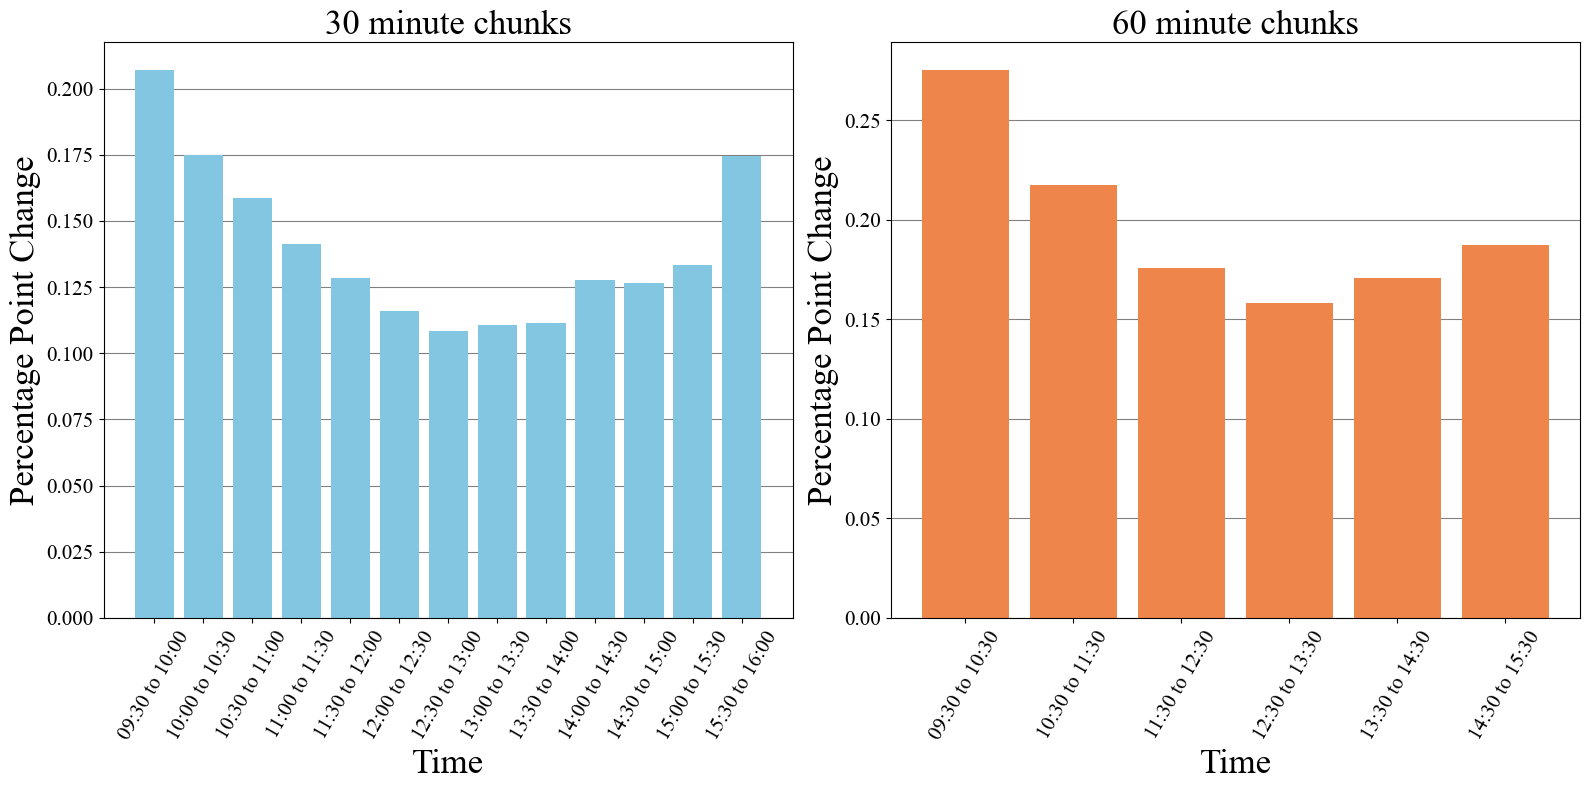

In [161]:
import seaborn as sns
sns.set_palette("muted")

y_30 = []
times_30 = [t.strftime('%H:%M') + " to " + times[i+1].strftime('%H:%M') for i, t in enumerate(times) if i != len(times) - 1]
y_60 = []
times_60 = [t.strftime('%H:%M') for i, t in enumerate(times) if i % 2 == 0]
times_60 = [t + " to " + times_60[i+1] for i, t in enumerate(times_60) if i != len(times_60) - 1]

for key, row in enumerate(abs_returns_arr):
    row = np.asarray(row)
    row = row[~np.isnan(row)]
    try:
        y_30.append(row[0])
    except:
        pass
    try:
        if key % 2 == 0:
            y_60.append(row[1])
    except:
        pass

# Create a figure with two subplots in the same row
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].set_title('30 minute chunks', fontsize = 25)
axes[0].set_xlabel('Time', fontsize = 25)
axes[0].set_ylabel('Percentage Point Change', fontsize = 25)
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(True, color='gray', zorder=0)
axes[0].bar(times_30, y_30, color=sns.color_palette()[9], zorder=2)
axes[0].set_xticklabels(times_30, rotation=60)

plt.xticks(rotation=45)

axes[1].set_title('60 minute chunks', fontsize = 25)
axes[1].set_xlabel('Time', fontsize = 25)
axes[1].set_ylabel('Percentage Point Change', fontsize = 25)
axes[1].xaxis.grid(False)
axes[1].yaxis.grid(True, color='gray', zorder=0)
axes[1].bar(times_60, y_60, color=sns.color_palette()[1], zorder=2)
axes[1].set_xticklabels(times_60, rotation=60)

plt.tight_layout()
plt.show()


## Algorithm Design

Our data mining has shown us that the largest percentage point changes are of coming from the times around the open and the close of each day. This makes sense as these are also the most volatile (large number of units being traded). This gives us something to focus on. If we can come up with a strategy that capture the volatility of the opening 30 to 60 minutes, then there is decent potential profits. 

We need a way of making a net gain both when the value increases or decreases, which sounds pretty impossible on the surface, but can be acomplished by with some slightly more sofisticated financial instruments and a careful attention to timing. 

Let's establish some terminology that will make it easier to explain how this idea works.
- **Position**: The ownership of a particular stock, security, or other financial instrument
- **Long Position**: This is a position in which if the value of the underlying asset goes up, then the value of this position also goes up acordingly. This can be as simple as buying and holding a stock.
- **Short Position**: The inverse of a long position (long versus short). If the value of the underlying asset goes up, the value of the position goes down acordingly. See https://en.wikipedia.org/wiki/Short_(finance) for more information.
- **Stop Loss**: This is a price point at which, if the price of the underlying asset is at or below this price, the asset gets sold. If you have a long position and the price of your asset is droping you want to avoid loosing money. So by setting a stop loss order, you are essentially *stoping any additional losses* by exiting that position.
- **Take Profit**: This is a price at which, if the price of the underlying asset is at or above this price, the asset gets sold. Same concept as the stop loss, except now that the asset has hopefully increased in value up to the price of your take profit, you want to sell it an *take your profits*.

So, if we were to enter both a long and a short position at the same time, it doesn't mater how the value of the underlying asset changes because the two positions will cancel each other out. However, if high volatility causes the asset to jump quickly up or down, we can try to come up with a way of selling the loosing position early (with a stop loss) and hold onto the winning position until it hits a take profit level, exiting with a net profit that is the difference between the take profit and stop loss levels. As long as the directional movement is high enough, and we can time our orders properly, this approach can be profitable. Note: This is the same concept behind a reverse iron condor, but if you already know what that is, then you probably aren't getting much out of my little tutorial to begin with.

Visualizing how these rules play out is much easier with a little simulation, see below.


In [185]:
from matplotlib.animation import FuncAnimation

x_percent_loss = -0.4 / 100
y_percent_gain = 1.6 / 100

df = market_by_days[3]
        
open_price = df.iloc[0]['average']  # Open position at the first minute's average price

betting_value = 2000 / 2

long_position = {'open_value': betting_value, 'current_value': betting_value}
short_position = {'open_value': betting_value, 'current_value': betting_value}
value_of_investment = [2000]

sl_value = betting_value * (1 + x_percent_loss) # stop-loss value
tp_value = betting_value * (1 + y_percent_gain) # take-profit value

final_bet_value = 0
prices = df["average"].tolist()
for key, current_price in enumerate(prices):

    if key == 0:
        continue

    temp_value_of_investment = final_bet_value
    if long_position:
        long_position['current_value'] = (1 + (current_price - open_price) / open_price) * long_position['open_value']
        temp_value_of_investment += long_position['current_value']
    if short_position:
        short_position['current_value'] = (1 + -1 * (current_price - open_price) / open_price) * short_position['open_value']
        temp_value_of_investment += short_position['current_value']
    value_of_investment.append(temp_value_of_investment)

    # Check for stop loss condition reached on long position
    if long_position and long_position['current_value'] <= sl_value:
        final_bet_value += sl_value
        long_position = None
        if short_position:
            first_position_exit = key
        else:
            second_position_exit = key
    # Check for stop loss condition reached on short position
    elif short_position and short_position['current_value'] <= sl_value:
        final_bet_value += sl_value
        short_position = None
        if long_position:
            first_position_exit = key
        else:
            second_position_exit = key
    
    # Check for take profit condition reached on long position
    if long_position and long_position['current_value'] >= tp_value:
        final_bet_value += tp_value
        value_of_investment[-1] = final_bet_value
        long_position = None
        if short_position:
            first_position_exit = key
        else:
            second_position_exit = key
    # Check for take profit condition reached on short position
    elif short_position and short_position['current_value'] >= tp_value:
        final_bet_value += tp_value
        value_of_investment[-1] = final_bet_value
        short_position = None
        if long_position:
            first_position_exit = key
        else:
            second_position_exit = key

if long_position or short_position:
    second_position_exit = key

x = np.arange(len(df))

fig, axs = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

top_plot = axs[0].plot([])[0]
axs[0].set_ylabel("Net Position Value", fontsize=25)

bot_plot = axs[1].plot([])[0]
axs[1].set_xlabel("Minutes from Open", fontsize=25)
axs[1].set_ylabel("S&P 500 Price", fontsize=25)

# Limiting range of plots
x_min, x_max = -10, 410
axs[0].set_xlim(x_min, x_max) 
axs[1].set_xlim(x_min, x_max)

y_range = max(value_of_investment) - min(value_of_investment)
axs[0].set_ylim(min(value_of_investment) - 0.1 * y_range, max(value_of_investment) + 0.1 * y_range)

y_range = max(prices) - min(prices)
lowest_rel_value = min(min(prices), prices[0] * (1 - y_percent_gain))
highest_rel_value = max(max(prices), prices[0] * (1 + y_percent_gain))
y_min = lowest_rel_value - 0.2 * y_range
y_max = highest_rel_value + 0.2 * y_range
axs[1].set_ylim(y_min, y_max)

fig.suptitle('Single Day Simulation', fontsize=25, x=0.60, y=0.98)

# Start making line labels
x_range = x_max - x_min
y_range = y_max - y_min
text_x_pos = x_max - 0.025 * x_range
height_above_line = y_range * 0.04
line_labels = {}
line_labels['initial_short_stop'] = axs[1].text(text_x_pos, 
                prices[0] * (1 - x_percent_loss) + height_above_line,
                'Short Stop-Loss', fontsize=12, color='gray', verticalalignment='center', horizontalalignment='right')
line_labels['initial_long_stop'] = axs[1].text(text_x_pos, 
                prices[0] * (1 + x_percent_loss) + height_above_line,
                'Long Stop-Loss', fontsize=12, color='gray', verticalalignment='center', horizontalalignment='right')

# Make initial stop loss horizontal lines
initial_short_stop = axs[1].axhline(y=prices[0] * (1 - x_percent_loss), color='tab:orange', linestyle='--')
initial_long_stop = axs[1].axhline(y=prices[0] * (1 + x_percent_loss), color='tab:orange', linestyle='--')

# Setup take profit line
if prices[first_position_exit] < prices[0]:
    tp_line = axs[1].axhline(y=prices[0] * (1 - y_percent_gain), color='green', linestyle='--')
    line_labels['tp'] = axs[1].text(text_x_pos, 
            prices[0] * (1 - y_percent_gain) + height_above_line,
            'Short Take-Profit', fontsize=12, color='gray', verticalalignment='center', horizontalalignment='right')
else:
    tp_line = axs[1].axhline(y=prices[0] * (1 + y_percent_gain), color='green', linestyle='--')
    line_labels['tp'] = axs[1].text(text_x_pos, 
            prices[0] * (1 + y_percent_gain) + height_above_line,
            'Long Take-Profit', fontsize=12, color='gray', verticalalignment='center', horizontalalignment='right')
tp_line.set_visible(False)
line_labels['tp'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0)    

def AnimationFunction(frame):

    top_plot.set_data((x[0:frame], value_of_investment[0:frame]))
    bot_plot.set_data((x[0:frame], prices[0:frame]))
    
    # Position exits
    if frame == first_position_exit:
        axs[1].axvline(x = first_position_exit, color = 'gray', dashes=[2,2])
        if prices[first_position_exit] < prices[0]:
            initial_long_stop.set_visible(False)
            line_labels['initial_long_stop'].set_visible(False)
        else:
            initial_short_stop.set_visible(False)
            line_labels['initial_short_stop'].set_visible(False)
        tp_line.set_visible(True)
        line_labels['tp'].set_visible(True)
    elif frame == second_position_exit:
        axs[1].axvline(x = second_position_exit, color = 'gray', dashes=[2,2])

anim_created = FuncAnimation(fig, AnimationFunction, frames=390, interval=50)
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html) 

plt.close()

In the above simulation we have taken a particular day from out dataset, opened a long and short position, and set an `x_percent_loss` and `y_percent_gain` value. The `x_percent_loss` is the percentage loss that either the long or short position must hit before being sold. The times at which the account value is flat is when either both the long and short positions are being held simultaneously, or both positions have been exited. In this example, the price of the S&P 500 increases from the opening value and hits the *short stop-loss* first. The short position gets sold, and the long position is held until it reaches the `y_percent_gain` value, leading to a nice net 1.2% profit for the day.

**This is of course a cherry picked example, but it shows the potential of this idea.**

The main downside of this approach is that that any sideways moving days, where there isn't a large price movement up or down, runs the risk of hitting both the long and short stop loss, resulting in a net loss for the day. We need it to hit a take profit value so that the algorithm can sell before any reversals. However, we don't want to set the take profit value too low, otherwise we might miss out on the upside of any high volatility days. There are some methods we can use to address this, and it's best to lay out our proposed algorithm as a series of steps/rules.

### Long-Short Strategy

1. Open a long and short position simultaneously at the start of trading day.
2. If either position loses x percent, sell the position. 
3. If the winning position reaches some threshold, move the remaining stop loss value to a breakeven position.
4. If the winning position gains y percent, implement a trailing stop loss.
5. At the end of day close any remaining positions.

Rule 3 helps cut down on the risk of a loosing day by moving the stop loss of the winning position to be a price where, if it is hit, then the profit from the winning position cancels out the loss from the loosing position. Rule 4 alows us to have some trailing stop loss that will prevent us from taking profit too early on big swing days. Finally rule 5 just prevents us from holding any positions overnight, allowing us to avoid any big market moves that might jump over our stop loss values and lead to more losses then we're comfortable taking.

Let's see what this looks like simulated.

In [1]:
from matplotlib.animation import FuncAnimation

def animate_simulation(market_day, 
                       x_percent_loss = -0.4 / 100, 
                       y_percent_gain = 1.6 / 100, 
                       be_threshold = 0.8 / 100, 
                       tslp = 0.4 / 100,
                       frames = 390,
                       interval = 50):
    """
    Visual animation of the algorithm being executed.

    Parameters
    ----------
    market_day: This index selects a specific day from the market_by_days list
    x_percent_loss: The ppc that either position is alowed to lose, after which point it gets sold.
                    This sets the starting stop loss values.
    y_percent_gain: Equivalent to take profit, once this ppc is reached a trailing stop less gets implemented
    be_threshold: The ppc which once reached will trigger the stop loss on the winning position to 
                  be moved to a break even position
    tslp: The trailing stop loss percentage, this is measured from the high peak or lowest trough of the day,
          depending on if the remaining position is long or short.
    frames: Integer umber of frames to animate (each frame is equivalent to 1 minute)
    interval: Integer delay between frames in milliseconds
    """

    df = market_by_days[market_day]
            
    open_price = df.iloc[0]['average']  # Open position at the first minute's average price

    betting_value = 2000 / 2

    long_position = {'open_value': betting_value, 'current_value': betting_value}
    short_position = {'open_value': betting_value, 'current_value': betting_value}
    value_of_investment = [2000]

    sl_value = betting_value * (1 + x_percent_loss) # stop-loss value
    tp_value = betting_value * (1 + y_percent_gain) # take-profit value
    be_value = betting_value * (1 + be_threshold) # breakeven threshold
    final_bet_value = 0
    trailing_sl_triggered = False
    be_value_triggered = False

    prices = df["average"].tolist()

    sl_positions = [[],[]] # keys/indexs list, tslp values list
    be_trigger = None # Key value for breakeven trigger being reached
    for key, current_price in enumerate(prices):

        if key == 0:
            continue

        temp_value_of_investment = final_bet_value
        if long_position:
            long_position['current_value'] = (1 + (current_price - open_price) / open_price) * long_position['open_value']
            temp_value_of_investment += long_position['current_value']
        if short_position:
            short_position['current_value'] = (1 + -1 * (current_price - open_price) / open_price) * short_position['open_value']
            temp_value_of_investment += short_position['current_value']
        value_of_investment.append(temp_value_of_investment)

        # Check for stop loss condition reached on long position
        if long_position and long_position['current_value'] <= sl_value:
            final_bet_value += sl_value
            value_of_investment[-1] += sl_value - long_position['current_value']
            long_position = None
            if short_position:
                first_position_exit = key
            else:
                second_position_exit = key
        # Check for stop loss condition reached on short position
        elif short_position and short_position['current_value'] <= sl_value:
            final_bet_value += sl_value
            value_of_investment[-1] += sl_value - short_position['current_value']
            short_position = None
            if long_position:
                first_position_exit = key
            else:
                second_position_exit = key


        # Trailing stop loss management
        if not trailing_sl_triggered:
            # Check for trailing stop condition reached on long position
            if long_position and long_position['current_value'] >= tp_value:
                sl_value = long_position['current_value'] * (1 - tslp)
                trailing_sl_triggered = True
                sl_positions[0].append(key)
                sl_positions[1].append(current_price * (1 - tslp))
            # Check for trailing stop condition reached on short position
            elif short_position and short_position['current_value'] >= tp_value:
                sl_value = short_position['current_value'] * (1 - tslp)
                trailing_sl_triggered = True
                sl_positions[0].append(key)
                sl_positions[1].append(current_price * (1 + tslp))
        else:
            if long_position and sl_value < long_position['current_value'] * (1 - tslp):
                sl_value = long_position['current_value'] * (1 - tslp)
                sl_positions[0].append(key)
                sl_positions[1].append(current_price * (1 - tslp))
            elif short_position and sl_value < short_position['current_value'] * (1 - tslp):
                sl_value = short_position['current_value'] * (1 - tslp)
                sl_positions[0].append(key)
                sl_positions[1].append(current_price * (1 + tslp))

        # Condition for moving sl_value to breakeven after one of the positions has stopped out
        if be_value_triggered == False:
            if long_position is not None and short_position is None and long_position['current_value'] >= be_value:
                sl_value = betting_value * (1 + -1 * x_percent_loss)
                be_trigger = key
                be_value_triggered = True
            if short_position is not None and long_position is None and short_position['current_value'] >= be_value:
                sl_value = betting_value * (1 + -1 * x_percent_loss)
                be_trigger = key
                be_value_triggered = True


    if long_position or short_position:
        second_position_exit = key

    x = np.arange(len(df))

    fig, axs = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

    top_plot = axs[0].plot([])[0]
    axs[0].set_ylabel("Net Position Value", fontsize=25)

    bot_plot = axs[1].plot([])[0]
    axs[1].set_xlabel("Minutes from Open", fontsize=25)
    axs[1].set_ylabel("S&P 500 Price", fontsize=25)

    # Limiting range of plots
    x_min, x_max = -10, 410
    axs[0].set_xlim(x_min, x_max) 
    axs[1].set_xlim(x_min, x_max)

    y_range = max(value_of_investment) - min(value_of_investment)
    axs[0].set_ylim(min(value_of_investment) - 0.1 * y_range, max(value_of_investment) + 0.1 * y_range)

    y_range = max(prices) - min(prices)
    lowest_rel_value = min(min(prices), prices[0] * (1 - y_percent_gain))
    highest_rel_value = max(max(prices), prices[0] * (1 + y_percent_gain))
    y_min = lowest_rel_value - 0.2 * y_range
    y_max = highest_rel_value + 0.2 * y_range
    axs[1].set_ylim(y_min, y_max)

    fig.suptitle('Single Day Simulation', fontsize=25, x=0.60, y=0.98)

    # Start making line labels
    x_range = x_max - x_min
    y_range = y_max - y_min
    text_x_pos = x_max - 0.025 * x_range
    height_above_line = y_range * 0.04
    line_labels = {}
    line_labels['initial_short_stop'] = axs[1].text(text_x_pos, 
                    prices[0] * (1 - x_percent_loss) + height_above_line,
                    'Short Stop-Loss', fontsize=12, color='gray', verticalalignment='center', horizontalalignment='right')
    line_labels['initial_long_stop'] = axs[1].text(text_x_pos, 
                    prices[0] * (1 + x_percent_loss) + height_above_line,
                    'Long Stop-Loss', fontsize=12, color='gray', verticalalignment='center', horizontalalignment='right')

    # Make initial stop loss horizontal lines
    initial_short_stop = axs[1].axhline(y=prices[0] * (1 - x_percent_loss), color='tab:orange', linestyle='--')
    initial_long_stop = axs[1].axhline(y=prices[0] * (1 + x_percent_loss), color='tab:orange', linestyle='--')

    # Setup be_threshold line
    if prices[first_position_exit] < prices[0]:
        be_threshold_line = axs[1].axhline(y=prices[0] * (1 - be_threshold), color='tab:purple', linestyle='--')
        line_labels['be_threshold'] = axs[1].text(text_x_pos, 
                    prices[0] * (1 - be_threshold) + height_above_line,
                    'Break Even Threshold', fontsize=12, color='gray', verticalalignment='center', horizontalalignment='right')
    else:
        be_threshold_line = axs[1].axhline(y=prices[0] * (1 + be_threshold), color='tab:purple', linestyle='--')
        line_labels['be_threshold'] = axs[1].text(text_x_pos, 
                prices[0] * (1 + be_threshold) + height_above_line,
                'Break Even Threshold', fontsize=12, color='gray', verticalalignment='center', horizontalalignment='right')
    be_threshold_line.set_visible(False)
    line_labels['be_threshold'].set_visible(False)

    # Setup take profit line
    if prices[first_position_exit] < prices[0]:
        tp_line = axs[1].axhline(y=prices[0] * (1 - y_percent_gain), color='green', linestyle='--')
        line_labels['tp'] = axs[1].text(text_x_pos, 
                prices[0] * (1 - y_percent_gain) + height_above_line,
                'Short Take-Profit', fontsize=12, color='gray', verticalalignment='center', horizontalalignment='right')
    else:
        tp_line = axs[1].axhline(y=prices[0] * (1 + y_percent_gain), color='green', linestyle='--')
        line_labels['tp'] = axs[1].text(text_x_pos, 
                prices[0] * (1 + y_percent_gain) + height_above_line,
                'Long Take-Profit', fontsize=12, color='gray', verticalalignment='center', horizontalalignment='right')
    tp_line.set_visible(False)
    line_labels['tp'].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0)                

    def AnimationFunction(frame):

        top_plot.set_data((x[0:frame], value_of_investment[0:frame]))
        bot_plot.set_data((x[0:frame], prices[0:frame]))
        
        # Position exits
        if frame == first_position_exit+1:
            axs[1].axvline(x = first_position_exit, color = 'gray', dashes=[2,2])
            if prices[first_position_exit] < prices[0]:
                initial_long_stop.set_visible(False)
                line_labels['initial_long_stop'].set_visible(False)
            else:
                initial_short_stop.set_visible(False)
                line_labels['initial_short_stop'].set_visible(False)
            be_threshold_line.set_visible(True)
            line_labels['be_threshold'].set_visible(True)

        # Managing be_threshold
        if be_trigger and frame == be_trigger+1:
            if prices[first_position_exit] < prices[0]:
                initial_short_stop.set_ydata((prices[0] * (1 + x_percent_loss)))
                line_labels['initial_short_stop'].set_position((text_x_pos, prices[0] * (1 + x_percent_loss) + height_above_line))
            else:
                initial_long_stop.set_ydata((prices[0] * (1 - x_percent_loss)))
                line_labels['initial_long_stop'].set_position((text_x_pos, prices[0] * (1 - x_percent_loss) + height_above_line))
            be_threshold_line.set_visible(False)
            line_labels['be_threshold'].set_visible(False)
            tp_line.set_visible(True)
            line_labels['tp'].set_visible(True)

        # Trailing Stop Losses
        if sl_positions and frame in sl_positions[0]:
            tp_line.set_visible(False)
            line_labels['tp'].set_visible(False)
            if prices[first_position_exit] < prices[0]:
                initial_short_stop.set_ydata((sl_positions[1][sl_positions[0].index(frame)]))
                line_labels['initial_short_stop'].set_position((text_x_pos, sl_positions[1][sl_positions[0].index(frame)] + height_above_line))
            else:
                initial_long_stop.set_ydata((sl_positions[1][sl_positions[0].index(frame)]))
                line_labels['initial_long_stop'].set_position((text_x_pos, sl_positions[1][sl_positions[0].index(frame)] + height_above_line))
        
        # 2nd position exit line
        if frame == second_position_exit+1:
            axs[1].axvline(x = second_position_exit, color = 'gray', dashes=[2,2])

    anim_created = FuncAnimation(fig, AnimationFunction, frames=frames, interval=interval)
    video = anim_created.to_html5_video()
    html = display.HTML(video)
    display.display(html)

    plt.close()

In [218]:
animate_simulation(market_day = 4)

C:\Users\ccard\AppData\Local\Temp\ipykernel_19328\879133395.py:217: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  initial_short_stop.set_ydata((prices[0] * (1 + x_percent_loss)))


In [232]:
animate_simulation(market_day = 32, 
                   x_percent_loss = -0.2 / 100, 
                   y_percent_gain = 0.8 / 100, 
                   be_threshold = 0.4 / 100, 
                   tslp = 0.3 / 100,
                   frames = 390,
                   interval = 75)

C:\Users\ccard\AppData\Local\Temp\ipykernel_19328\879133395.py:220: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  initial_long_stop.set_ydata((prices[0] * (1 - x_percent_loss)))
C:\Users\ccard\AppData\Local\Temp\ipykernel_19328\879133395.py:235: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  initial_long_stop.set_ydata((sl_positions[1][sl_positions[0].index(frame)]))


In the first of the two simulated examples (market day 4), the breakeven threshold variable works to ensure that there is no net loss. This day did not have much price volatility but we still managed to avoid loosing money. 

In the second animated example (market day 0), the trailing stop loss works as intended, and allows us to capture slightly more profit than if we had just set the take profit by itself.

### Algorithm Metrics: Yearly Return, Maximum Drawdown (%), Longest Drawdown

Great, now that we've established out algorithm, let's see how it performs! An easy way of measuring performance is by average yearly return. The standard yearly return of the S&P 500 is about 10%, so if we can beat this than that's pretty good. Another metric we should consider is something known as **drawdown** which refers to how much the value of an asset has dropped from its peak. We will use both *max drawdown percentage* (the maximum percentage drop from a peak) and *longest drawdown* (the length in days of the longest period of drawdown) as our metrics. These are both important to consider because they play a big role in the psycological aspect of any investment strategy. If our algorithm returns 50% per year returns (which would be insanely good), but has a maximum drawdown of 90%, then that means at some point during the simulated timeframe we lost nearly everything. This can make it very difficult to stick with an algorithm; that type of volatility can be just as detrimental to our mental game as it is to our account value.

### Algorithm Testing Framework

We also need to talk about how we simulate across multiple days. Our metrics depend on day to day effects (compound return, continuous days of drawdown, ect) and our algorithm doesn't depend on day to day trends (no positions held overnight). Given that we want to be able to test the effectivness of this algorithm with with real world market behavior, the ideal situation would be to have multiple five to ten year sub sets that we could average the performance over. The averaging is an important step because it will prevent overfitting later on. However, minute by minute data hasn't existed before the last 20 or so years. There are some techniques to overcome this issue such as a moving range (ex: 16 unique 5 year chunks in a 20 year stretch) and Monte Carlo methods. It will be sufficient to take random subsets of the our entire ~12 years of data. This will allow us to generate a huge training data set, with the drawback that the days in each subset will be entirely uncorrelated. This isn't an unresonable approximation, as it's often stated that markets behave essentially like random noise with non-static correlations. This is still an active area of research though, see https://www.sciencedirect.com/science/article/pii/S0264999318306849 for more information. For our purposes, we use this simplifying approximation and gladly ignore any consequences.

The code below works exactly the same as the simulations we ran early but keeps track of a `balance` list which represents the account value over the course of multiple days. This is used to calculate the various metrics, as well as a few more useful pieces of information.

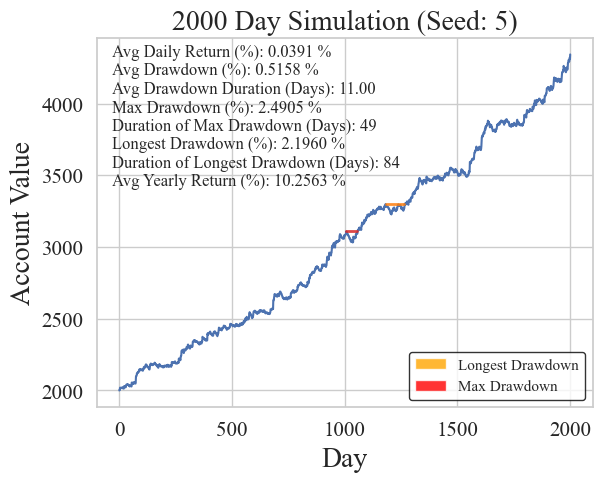

In [108]:
debug = False # Make this true to print out all the debug messages

def my_algorithm(random_seed, day_num, starting_balance, x_percent_loss, y_percent_gain, be_threshold, tslp):
    """
    Simulates returns using the algorithm described in the markdown above
    and returns a list of daily balances along with various statistics about
    the returns and drawdowns.
    """

    random.seed(random_seed)

    balance = [starting_balance]

    for df in random.sample(market_by_days, day_num):
        open_price = df.iloc[0]['average']  # Open position at the first minute's average price

        betting_value = balance[-1] / 2

        balance.append(0) # Betting everything, so current balance for the day is zero

        long_position = {'open_value': betting_value, 'current_value': betting_value}
        short_position = {'open_value': betting_value, 'current_value': betting_value}

        sl_value = betting_value * (1 + x_percent_loss) # stop-loss value
        tp_value = betting_value * (1 + y_percent_gain) # take-profit value
        be_value = betting_value * (1 + be_threshold)
        final_bet_value = 0
        trailing_sl_triggered = False
        be_value_triggered = False

        debug_msg_arr = []
        prices = df["average"].tolist()
        for current_price in prices:

            if not long_position and not short_position:
                break # break loop once all positions are closed out


            if long_position:
                debug_msg_arr.append(("long_position", round(long_position['current_value'], 5), round(long_position['current_value'] / long_position['open_value'], 5)))
                long_position['current_value'] = (1 + (current_price - open_price) / open_price) * long_position['open_value']
            if short_position:
                debug_msg_arr.append(("short_position", round(short_position['current_value'], 5), round(short_position['current_value'] / short_position['open_value'], 5)))
                short_position['current_value'] = (1 + -1 * (current_price - open_price) / open_price) * short_position['open_value']


            # Check for stop loss condition reached on long position
            if long_position and long_position['current_value'] <= sl_value:
                debug_msg_arr.append(("Stop loss on long_position reached with long value ratio at ", round(long_position['current_value'] / long_position['open_value'], 5)))
                final_bet_value += sl_value # Assume perfect order filling, no slippage
                long_position = None
            # Check for stop loss condition reached on short position
            elif short_position and short_position['current_value'] <= sl_value:
                debug_msg_arr.append(("Stop loss on short_position reached with short value ratio at ", round(short_position['current_value'] / short_position['open_value'], 5)))
                final_bet_value += sl_value # Assume perfect order filling, no slippage
                short_position = None


            # Trailing stop loss management
            if not trailing_sl_triggered:
                # Check for trailing stop condition reached on long position
                if long_position and long_position['current_value'] >= tp_value:
                    debug_msg_arr.append(("Trigging trailing stop loss on long at ", round(long_position['current_value'] / long_position['open_value'], 5)))
                    sl_value = long_position['current_value'] * (1 - tslp)
                    debug_msg_arr.append(("Setting sl_value to ", round(sl_value, 5), "relative to ", round(long_position['current_value'], 5)))
                    trailing_sl_triggered = True
                # Check for trailing stop condition reached on short position
                elif short_position and short_position['current_value'] >= tp_value:
                    debug_msg_arr.append(("Trigging trailing stop loss on short at ", round(short_position['current_value'] / short_position['open_value'], 5)))
                    sl_value = short_position['current_value'] * (1 - tslp)
                    debug_msg_arr.append(("Setting sl_value to ", round(sl_value, 5), "relative to ", round(short_position['current_value'], 5)))
                    trailing_sl_triggered = True
            else:
                if long_position and sl_value < long_position['current_value'] * (1 - tslp):
                    sl_value = long_position['current_value'] * (1 - tslp)
                    debug_msg_arr.append(("Updating trailing stop loss to", round(sl_value, 5), "with long at", round(long_position['current_value'], 5)))
                elif short_position and sl_value < short_position['current_value'] * (1 - tslp):
                    sl_value = short_position['current_value'] * (1 - tslp)
                    debug_msg_arr.append(("Updating trailing stop loss to", round(sl_value, 5), "with short at", round(short_position['current_value'], 5)))


            # Condition for moving sl_value to breakeven after one of the positions has stopped out
            if be_value_triggered == False:
                if long_position is not None and short_position is None and long_position['current_value'] >= be_value:
                    debug_msg_arr.append(("be_value on long_position reached with short at ", round(long_position['current_value'] / long_position['open_value'], 5)))
                    sl_value = betting_value * (1 + -1 * x_percent_loss)
                    be_value_triggered = True
                if short_position is not None and long_position is None and short_position['current_value'] >= be_value:
                    debug_msg_arr.append(("be_value on short_position reached with short at ", round(short_position['current_value'] / short_position['open_value'], 5)))
                    sl_value = betting_value * (1 + -1 * x_percent_loss)
                    be_value_triggered = True


        # Close any remaining positions at the end of the day
        if long_position:
            debug_msg_arr.append(("Closing long position at ", long_position['current_value']))
            final_bet_value += long_position['current_value']
        if short_position:
            debug_msg_arr.append(("Closing short position at ", short_position['current_value']))
            final_bet_value += short_position['current_value']
        
        balance[-1] += final_bet_value

        if debug:
            for msg in debug_msg_arr:
                print(msg)
            print()


    balance = np.asarray(balance)

    # Calculate average daily return
    daily_returns = np.diff(balance) / balance[:-1]
    average_daily_return = np.mean(daily_returns) * 100

    # Calculate drawdowns
    peak = balance[0]
    drawdowns = [[], [], []]  # [[start_day], [stop_day], [drawdown_value]]
    in_drawdown = False
    current_drawdown_value = 0
    max_drawdown_value = 0

    for i, b in enumerate(balance):
        if b >= peak:
            if in_drawdown:
                drawdown_end = i-1
                drawdowns[0].append(drawdown_start)
                drawdowns[1].append(drawdown_end)
                drawdowns[2].append(max_drawdown_value)
                max_drawdown_value = 0
            in_drawdown = False
            peak = b
        else:
            if not in_drawdown:
                drawdown_start = i-1
            in_drawdown = True
            current_drawdown_value = (peak - b) / peak
            if max_drawdown_value < current_drawdown_value:
                max_drawdown_value = current_drawdown_value
            if i == len(balance) - 1:
                drawdown_end = i
                drawdowns[0].append(drawdown_start)
                drawdowns[1].append(drawdown_end)
                drawdowns[2].append(max_drawdown_value)

    average_drawdown = np.mean(drawdowns[2]) * 100

    max_drawdown_byper = np.max(drawdowns[2]) * 100 # Convert max drawdown to percentage
    max_drawdown_byper_start = drawdowns[0][np.argmax(drawdowns[2])] # measured by percentage
    max_drawdown_byper_end = drawdowns[1][np.argmax(drawdowns[2])] # measured by percentage
    duration_of_max_drawdown = max_drawdown_byper_end - max_drawdown_byper_start # Duration in days of the maximum drawdown (by percent)
    
    drawdown_durations = np.asarray([drawdowns[1][i] - drawdowns[0][i] for i in range(len(drawdowns[0]))])
    max_drawdown_bydur = drawdowns[2][np.argmax(drawdown_durations)] * 100
    max_drawdown_bydur_start = drawdowns[0][np.argmax(drawdown_durations)] # measured by duration
    max_drawdown_bydur_end = drawdowns[1][np.argmax(drawdown_durations)] # measured by duration
    duration_of_longest_drawdown = max_drawdown_bydur_end - max_drawdown_bydur_start # Duration in days of the longest drawdown

    # Calculate average drawdown duration
    average_drawdown_duration = np.mean(drawdown_durations)

    # Calculate average yearly return
    average_yearly_return = ((balance[-1] / balance[0]) ** (252 / len(balance)) - 1) * 100

    return {
        "Balance" : balance,
        "drawdowns": drawdowns,
        "Avg Daily Return": average_daily_return,
        "Avg Drawdown": average_drawdown,
        "Avg Drawdown Duration (Days)": average_drawdown_duration,
        "Max Drawdown By Percent": max_drawdown_byper,
        "Max Drawdown By Percent Start": max_drawdown_byper_start,
        "Max Drawdown By Percent End": max_drawdown_byper_end,
        "Duration of Max Drawdown (Days)": duration_of_max_drawdown,
        "Max Drawdown By Duration": max_drawdown_bydur,
        "Max Drawdown By Duration Start": max_drawdown_bydur_start,
        "Max Drawdown By Duration End": max_drawdown_bydur_end,
        "Duration of Longest Drawdown (Days)": duration_of_longest_drawdown,
        "Avg Yearly Return": average_yearly_return
        }

random_seed = 5
day_num = 2000 # Number of days to simulate over

# Assuming the initial balance is $2000
starting_balance = 2000

x_percent_loss = -0.2 / 100  # x percent loss threshold
y_percent_gain = 3.5 / 100  # y percent gain threshold
be_threshold = 0.5 / 100 # breakeven threshold
tslp = 1.5 / 100 # trailing stop loss percentage

report = my_algorithm(random_seed, day_num, starting_balance, x_percent_loss, y_percent_gain, be_threshold, tslp)

balance = report["Balance"]
average_daily_return = report["Avg Daily Return"]
average_drawdown = report["Avg Drawdown"]
average_drawdown_duration = report["Avg Drawdown Duration (Days)"]
max_drawdown_byper = report["Max Drawdown By Percent"]
max_drawdown_byper_start = report["Max Drawdown By Percent Start"]
max_drawdown_byper_end = report["Max Drawdown By Percent End"]
duration_of_max_drawdown = report["Duration of Max Drawdown (Days)"]
max_drawdown_bydur = report["Max Drawdown By Duration"]
max_drawdown_bydur_start = report["Max Drawdown By Duration Start"]
max_drawdown_bydur_end = report["Max Drawdown By Duration End"]
duration_of_longest_drawdown = report["Duration of Longest Drawdown (Days)"]
average_yearly_return = report["Avg Yearly Return"]

x = np.arange(0, len(balance), 1)
plt.plot(x, balance)

# Highlight the period of maximum drawdown with a red bar
x = [max_drawdown_byper_start, max_drawdown_byper_end]
y = [balance[max_drawdown_byper_start], balance[max_drawdown_byper_start]]
plt.plot(x, y, color='tab:red', alpha=0.85, linewidth=2)

# Highlight the period of longest drawdown with an orange bar
x = [max_drawdown_bydur_start, max_drawdown_bydur_end]
y_range = np.max(balance) - np.min(balance)
if (max_drawdown_byper_start, max_drawdown_byper_end) == (max_drawdown_bydur_start, max_drawdown_bydur_end):
    y = [balance[max_drawdown_bydur_start] + 0.025 * y_range, balance[max_drawdown_bydur_start]  + 0.025 * y_range]
else:
    y = [balance[max_drawdown_bydur_start], balance[max_drawdown_bydur_start]]
plt.plot(x, y, color='tab:orange', alpha=0.85, linewidth=2)

  
legend_labels = ["Longest Drawdown", "Max Drawdown"]
legend_patches = [mpatches.Patch(facecolor='orange', alpha=0.8),
                mpatches.Patch(facecolor='red', alpha=0.8)]

# Create the legend in the bottom right-hand corner
plt.legend(legend_patches, legend_labels, loc='lower right', fancybox=True, 
    borderaxespad=0.5, frameon=True, edgecolor='black')

plt.text(0.03, 0.95, f'Avg Daily Return (%): {average_daily_return:.4f} %', transform=plt.gca().transAxes)
plt.text(0.03, 0.90, f'Avg Drawdown (%): {average_drawdown:.4f} %', transform=plt.gca().transAxes)
plt.text(0.03, 0.85, f'Avg Drawdown Duration (Days): {average_drawdown_duration:.2f}', transform=plt.gca().transAxes)
plt.text(0.03, 0.80, f'Max Drawdown (%): {max_drawdown_byper:.4f} %', transform=plt.gca().transAxes)
plt.text(0.03, 0.75, f'Duration of Max Drawdown (Days): {duration_of_max_drawdown}', transform=plt.gca().transAxes)
plt.text(0.03, 0.70, f'Longest Drawdown (%): {max_drawdown_bydur:.4f} %', transform=plt.gca().transAxes)
plt.text(0.03, 0.65, f'Duration of Longest Drawdown (Days): {duration_of_longest_drawdown}', transform=plt.gca().transAxes)
plt.text(0.03, 0.60, f'Avg Yearly Return (%): {average_yearly_return:.4f} %', transform=plt.gca().transAxes)

plt.title(f"{day_num} Day Simulation (Seed: {random_seed})", fontsize = 20)

plt.ylabel("Account Value", fontsize = 20)
plt.xlabel("Day", fontsize = 20)

plt.show()

 The balance as a function of time is plotted above. Out of the gate the algorithm seems to perform relatively well, with minimal drawdown percentage, and a resonable drawdown duration. For the most part the balance seems to be a steadily increasing function with some moderate noise. Note: There are about 252 trading days in a year (leap years make things complicated), so 2000 days is roughly 8 years. Despite it's solid performance on the drawdowns, the avg yearly return is still pretty much the same as the standard S&P 500. This is only for one seed, one random set of 2000 days. Let's try running this a few times more times to get an idea of how it performs.

#### 12 random, 2000 day simulations

(Here Dd stands for Drawdown)

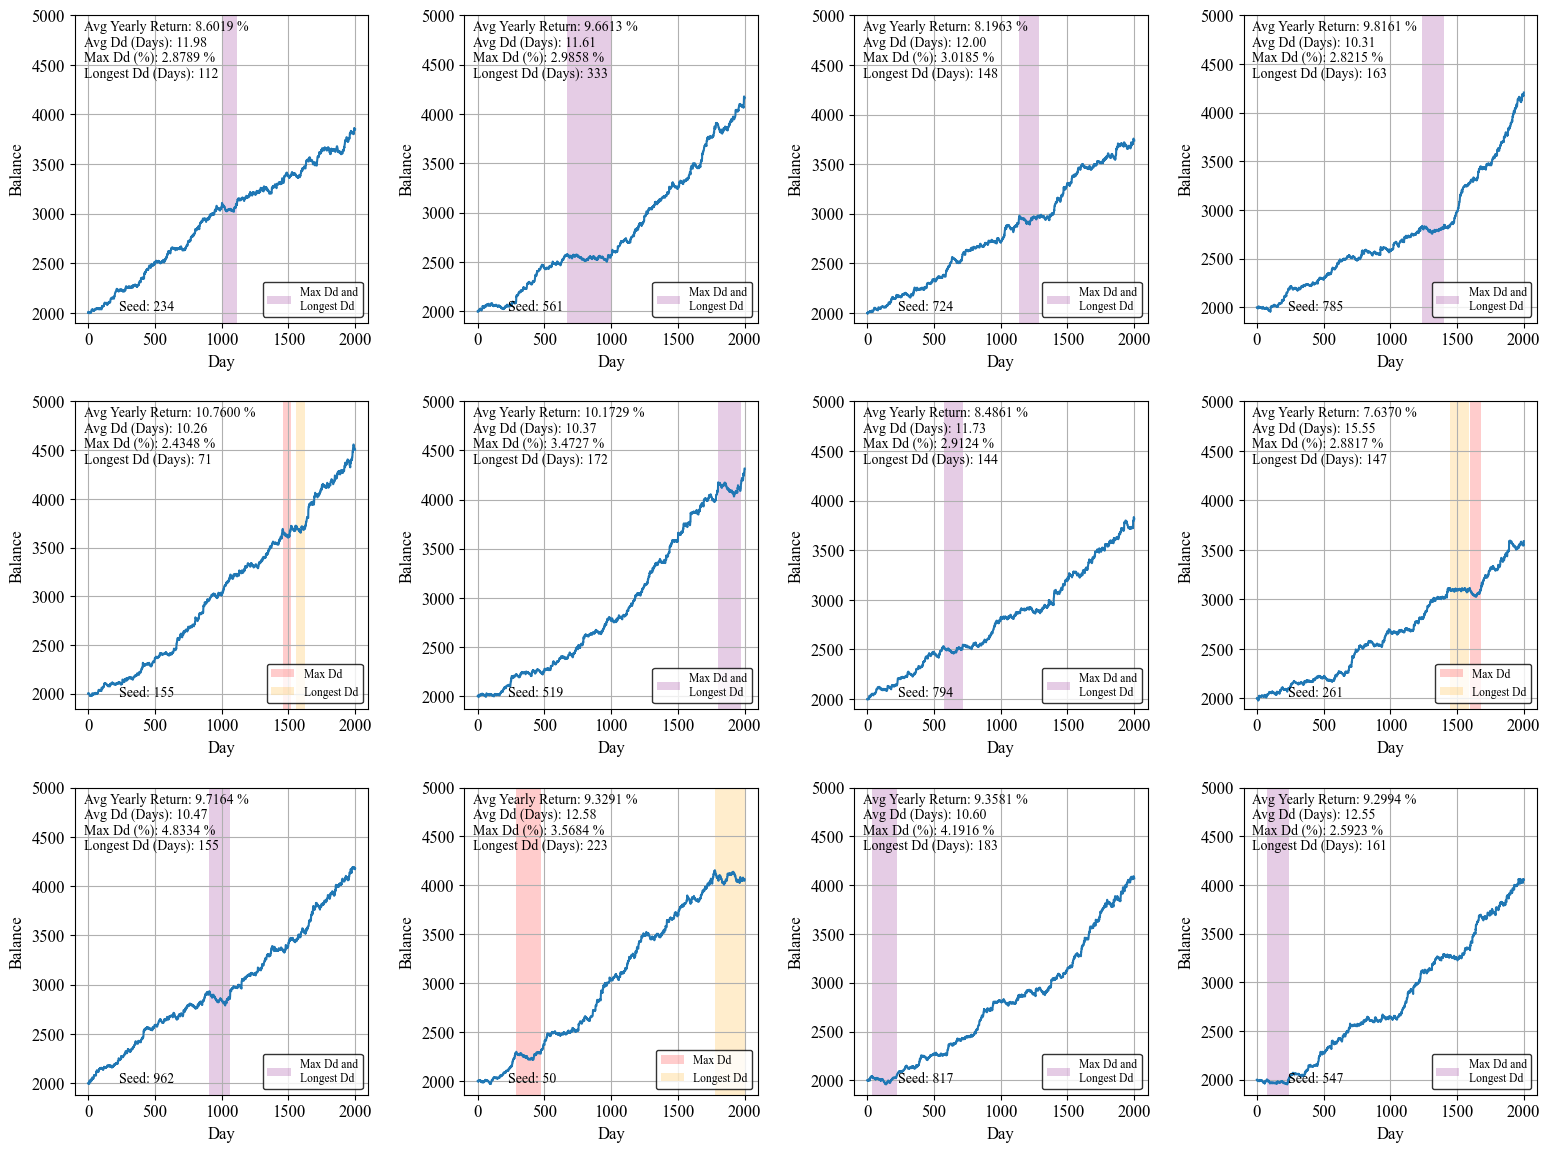

In [21]:
import matplotlib.patches as mpatches

# Create a 3x4 grid of subplots
nrows = 3
ncols = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
fig.tight_layout(pad=3.0)

day_num = 2000
starting_balance = 2000

x_percent_loss = -0.2 / 100  # x percent loss threshold
y_percent_gain = 3.5 / 100  # y percent gain threshold
be_threshold = 0.5 / 100 # breakeven threshold
tslp = 1.5 / 100 # trailing stop loss percentage

# Loop through the random seeds and parameter sets
seed_counter = 0
seeds = [random.randint(1, 1000) for _ in range(12)]
for i in range(nrows):
    for j in range(ncols):
        # Simulate the algorithm for the current random seed and parameter set
        report = my_algorithm(seeds[seed_counter], day_num, starting_balance, x_percent_loss, y_percent_gain, be_threshold, tslp)

        balance = report["Balance"]

        # Plot the balance on the corresponding subplot
        axs[i, j].plot(np.arange(0, len(balance), 1), balance)

        # Add text to the subplot
        axs[i, j].text(0.03, 0.95, f'Avg Yearly Return: {report["Avg Yearly Return"]:.4f} %', transform=axs[i, j].transAxes, fontsize=12)
        axs[i, j].text(0.03, 0.90, f'Avg Dd (Days): {report["Avg Drawdown Duration (Days)"]:.2f}', transform=axs[i, j].transAxes, fontsize=12)
        axs[i, j].text(0.03, 0.85, f'Max Dd (%): {report["Max Drawdown By Percent"]:.4f} %', transform=axs[i, j].transAxes, fontsize=12)
        axs[i, j].text(0.03, 0.80, f'Longest Dd (Days): {report["Duration of Longest Drawdown (Days)"]}', transform=axs[i, j].transAxes, fontsize=12)

        axs[i, j].text(0.15, 0.04, f"Seed: {seeds[seed_counter]}", transform=axs[i, j].transAxes)

        # Highlight the period of maximum drawdown with a red bar
        max_p_start = report["Max Drawdown By Percent Start"]
        max_p_end = report["Max Drawdown By Percent End"]
        
        # Highlight the period of longest drawdown with a blue bar
        max_d_start = report["Max Drawdown By Duration Start"]
        max_d_end = report["Max Drawdown By Duration End"]
        
        if max_p_start == max_d_start and max_p_end == max_d_end:
            axs[i, j].axvspan(max_p_start, max_p_end, facecolor='purple', alpha=0.2)    
            legend_labels = ["Max Dd and\nLongest Dd"]
            legend_patches = [mpatches.Patch(facecolor='purple', alpha=0.2)]
        else:
            legend_labels = ["Max Dd", "Longest Dd"]
            legend_patches = [mpatches.Patch(facecolor='red', alpha=0.2),
                  mpatches.Patch(facecolor='orange', alpha=0.2)]
            axs[i, j].axvspan(max_p_start, max_p_end, facecolor='red', alpha=0.2)
            axs[i, j].axvspan(max_d_start, max_d_end, facecolor='orange', alpha=0.2)

        # Create the legend in the bottom right-hand corner
        axs[i, j].legend(legend_patches, legend_labels, loc='lower right', fancybox=True, 
            borderaxespad=0.5, fontsize=12, frameon=True, 
            edgecolor='black')

        seed_counter += 1

# Add common labels
for ax in axs.flat:
    ax.set(xlabel="Day", ylabel="Account Value")
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_yticks([2000, 2500, 3000, 3500, 4000, 4500, 5000]) 
    ax.set_yticklabels([2000, 2500, 3000, 3500, 4000, 4500, 5000])

# Show the plot
plt.show()

Alright, at least with this small sample of simulations our results are pretty consistent

Now what we really need to do is run this simulation many more times look at the performance metric statistics across a lot of seeds.

#### Statistics from 100 random, 2000 day, runs

In [114]:
import random
import numpy as np
import matplotlib.pyplot as plt


def stats_from_many_runs(parameters, categories, number_of_sims):

    day_num = parameters[0]
    starting_balance = parameters[1]
    x_percent_loss = parameters[2]
    y_percent_gain = parameters[3]
    be_threshold = parameters[4]
    tslp = parameters[5]

    data = [[] for i in categories]

    seeds = [int(i) for i in range(0, number_of_sims, 1)]
    for seed in seeds:
        report = my_algorithm(seed, day_num, starting_balance, x_percent_loss, y_percent_gain, be_threshold, tslp)
        for i in range(len(categories)):
            data[i].append(report[categories[i]])
    

    # Calculate mean, max, min, and values within one standard deviation
    def calculate_summary_stats(data):
        mean = np.mean(data)
        max_val = np.max(data)
        min_val = np.min(data)
        std_dev = np.std(data)
        within_std_dev = [x for x in data if mean - std_dev <= x <= mean + std_dev]
        return mean, max_val, min_val, within_std_dev

    # Calculate summary statistics for each category
    stats = [calculate_summary_stats(i) for i in data]

    return data, stats

In [115]:
# Parameters
day_num = 2000
starting_balance = 2000
x_percent_loss = -0.2 / 100  # x percent loss threshold
y_percent_gain = 3.5 / 100  # y percent gain threshold
be_threshold = 0.5 / 100 # breakeven threshold
tslp = 1.5 / 100 # trailing stop loss percentage

categories = [
    "Avg Daily Return",
    "Avg Yearly Return",
    "Avg Drawdown",
    "Avg Drawdown Duration (Days)",
    "Max Drawdown By Percent",
    "Duration of Longest Drawdown (Days)"
]

number_of_sims = 100

# Unoptimized parameters
data_unop, stats_unop = stats_from_many_runs([day_num, starting_balance, x_percent_loss, y_percent_gain, be_threshold, tslp], categories, number_of_sims)

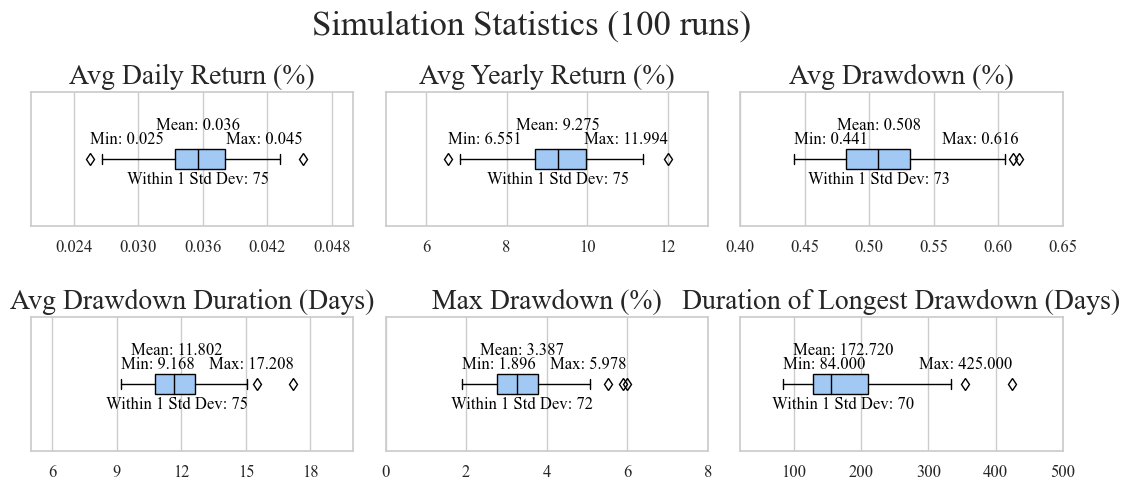

In [117]:
from matplotlib import ticker
import seaborn as sns

nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 2.5*nrows))
fig.tight_layout(pad=3.0)


custom_titles = [
    "Avg Daily Return (%)",
    "Avg Yearly Return (%)",
    "Avg Drawdown (%)",
    "Avg Drawdown Duration (Days)",
    "Max Drawdown (%)",
    "Duration of Longest Drawdown (Days)"
]
custom_xlims = [
    (0.02, 0.05),
    (5, 13),
    (0.4, 0.65),
    (5, 20),
    (0, 8),
    (20, 500)
]

for i in range(len(categories)):
    ax = axs.flatten()[i]
    ax.boxplot(data_unop[i], vert=False, sym="d", 
        boxprops=dict(facecolor=sns.color_palette("pastel")[0]), 
        medianprops=dict(color='black'),
        patch_artist=True)
    ax.set_title(custom_titles[i])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.set_xlim(custom_xlims[i])
    ax.grid(True)
    
    # Add statistics text to the plot
    text_color = 'black'
    mean, max_val, min_val, within_std_dev = stats_unop[i]
    ax.text(mean, 1.25, f"Mean: {mean:.3f}", color=text_color, verticalalignment='center',horizontalalignment='center')
    ax.text(max_val, 1.15, f"Max: {max_val:.3f}", color=text_color, verticalalignment='center', horizontalalignment='right')
    ax.text(min_val, 1.15, f"Min: {min_val:.3f}", color=text_color, verticalalignment='center', horizontalalignment='left')
    ax.text(mean, 0.85, f"Within 1 Std Dev: {len(within_std_dev)}", color=text_color, verticalalignment='center', horizontalalignment='center')

plt.subplots_adjust(wspace=0.1)
fig.suptitle(f"Simulation Statistics ({number_of_sims} runs)", y=1.05, fontsize = 25)
plt.show()

## Parameter Optimization with Genetic Algorithms (GAs)

Awesome, now we have a solid baseline of the algorithm's performance, at least with the current parameters. Compared to a buy and hold strategy of the S&P 500, we have significantly lower maximum drawdowns and drawdown durations ([source](https://www.putnam.com/dcio/content/perspectives/9535-sp-500-index-earnings-and-p-e-multiple-performance-during-u-s-recessions#:~:text=The%20average%20S%26P%20500%20drawdown,seven%20of%20the%20ten%20periods.&text=During%20recessions%2C%20U.S.%20companies%20typically,%2FE%20multiples%2C%20and%20price.)) The average yearly returns however aren't bad, but they are definetly at or a little below the standard 10% value (*any excess return compared to the benchmark 10% average of the S&P 500 is commonly refered to as "alpha"*). We have one last trick up our sleve though; the parameters we have been using for our 4 variables in our algorithm are just ones that I chose from a little trial and error, there is likely some performance still left on the table.

Similar to hill climbing or simulated anealing, GAs are a way of finding the optimal solution to a problem. GAs are a metaheuristic that mimics nature by using a "population" of solutions, and then selectively breeding and mutating them to try to find the "fitest" possible solution. They can be very efficent due to the fact that information about the phase space is shared between members of the population through breeding. We can use the python package `pygad` to do most of the work for us, and set up the algorithm with a few specialty crossover (breeding) and mutation functions to make sure that we avoid an solutions that don't open simple logic (like setting our trailing stop loss above our take profit).

We also need to be careful about how we define fitness, as this is essentially the value being optimized. Values that score better on the fitness function have a better chance of having their genes passed on to the next generation. For us, we want the largest yearly return with the smallest drawdown values. An easy solution is to write 3 seperate fitness functions for our 3 metrics, plotted below. We will use hyperbolic tangent (tanh) functions to get a smoothly varying number between 0 and 1 depending on the performance metric. We will center each tanh function near the average values from our 100 simulated runs.

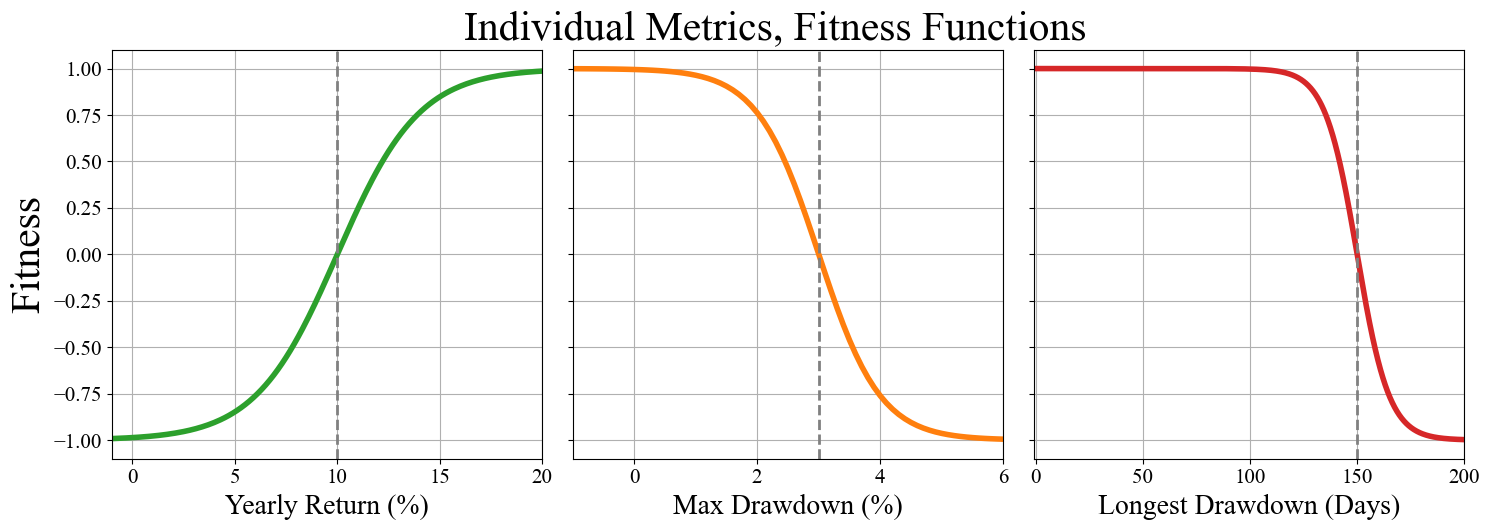

In [22]:
x = np.arange(-1, 200, 0.1)
y_yearly = np.tanh(x / 4 - 2.5)
y_maxdd = -1 * np.tanh(x - 3)
y_longdd = -1 * np.tanh(x / 15 - 10)

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
plt.subplots_adjust(hspace=0)

axs[0].plot(x, y_yearly, color="tab:green", linewidth=4)
axs[1].plot(x, y_maxdd, color="tab:orange", linewidth=4)
axs[2].plot(x, y_longdd, color="tab:red", linewidth=4)

axs[0].set_xlim(-1,20)
axs[0].axvline(x=10, color='gray', linestyle='--', linewidth=2)
axs[0].set_xlabel('Yearly Return (%)', fontsize=20)
axs[0].set_ylabel('Fitness', fontsize=30)

axs[1].set_xlim(-1,6)
axs[1].axvline(x=3, color='gray', linestyle='--', linewidth=2)
axs[1].set_xlabel('Max Drawdown (%)', fontsize=20)

axs[2].set_xlim(-1,200)
axs[2].axvline(x=150, color='gray', linestyle='--', linewidth=2)
axs[2].set_xlabel('Longest Drawdown (Days)', fontsize=20)
    
# Adjust the layout and remove vertical space between subplots
plt.tight_layout(h_pad=0)

fig.suptitle("Individual Metrics, Fitness Functions", y=1.05, x = 0.52, fontsize = 30)

# Show the plot
plt.show()

We can then combine all 3 of these together into a single fitness function simply by adding them all together. We have our GA set up to maximize a value, so we can take the inverse of 1 / (6 - (4 * yearly fitness + max drawdown fitness + longest drawdown fitness)) as our final fitness function. Multiplying the yearly fitness by 4 is a quick way of wieghting its importance higher than the other two metrics. We do at the end of the day, want to find something which can outperform the underlying asset.

The final note about how the fitness is determined is something we actually aluded to earlier. We want the GA to find the optimial solution to any random set of days. This means we can't use the same random set every time the fitness function is called, otherwise it will only find the optimal values for *that specific set of days*. To get around this, we can use the same 30 random subsets and average the metrics over them. 

This is a necessary step for ensuring the quality of our final optimization, but we are reaching the limit of what is considered resonable computational time. We're looking at a maximum of 390 minutes in every day, for 2000 days, for 30 different random configurations, for 16 different sets of paramters (solutions). It's possible that we could come up with a cheaper fitness function such as evaluating on a 5 or 10 minute time frame, which would actually be a very reasonable compromise. Or we can just go the brute force route and put our fancy CPUs to use buy using pygad's built in multiprocessing capabilities. Doing it this way will also allow us to be greedy with our fitness function and average over a larger number of random configurations. 

Multiprocessing isn't the kind of thing that can be done in a Jupyter notebook, so the modified code is in the the `parallel_GA.py` file, but the main bulk of it is also copied below if you'd like to see a genetic algorithm is implemented with pygad.

In [5]:
# This will run, but will take a long time during the evaluation stage because the population is running sequentially instead of in parallel.

import pygad

day_num = 100
starting_balance = 2000

def are_params_logical(solution):

    x_percent_loss = solution[0]
    y_percent_gain = solution[1]
    be_threshold = solution[2]
    tslp = solution[3]

    if -1*x_percent_loss > (y_percent_gain - tslp):
        return False
    elif be_threshold < -1 * x_percent_loss:
        return False
    elif be_threshold > y_percent_gain:
        return False
    elif tslp > y_percent_gain:
        return False
    elif x_percent_loss >= 0:
        return False
    elif y_percent_gain <= 0:
        return False
    elif be_threshold <= 0:
        return False
    elif tslp <= 0:
        return False
    
    return True

def fitness_function(ga_instance, solution, solution_idx):
    x_percent_loss = solution[0]
    y_percent_gain = solution[1]
    be_threshold = solution[2]
    tslp = solution[3]


    if not(are_params_logical(solution)):
        print("Solution did not satisfy logical requirements")
        return -99999

    profit_fitness = 0
    max_drawdown_fitness = 0
    longest_drawdown_dur_fitness = 0
    seeds = [int(i) for i in np.arange(0, 30, 1)]
    seeds = [1]
    for seed in seeds:
        report = my_algorithm(seed, day_num, starting_balance, x_percent_loss / 100, y_percent_gain / 100, be_threshold / 100, tslp / 100)

        # Use this when using algorithm with no slippage
        profit_fitness += np.tanh(report["Avg Yearly Return"] / 4 - 2.5) # tanh function stretched and centered at 10
        max_drawdown_fitness += -1 * np.tanh(report["Max Drawdown By Percent"] - 3) # negative tanh function centered at 3.0
        longest_drawdown_dur_fitness += -1 * np.tanh(report["Duration of Longest Drawdown (Days)"] / 15 - 10) # Centered near 150

    # Average the fitnesses over the number of runs
    profit_fitness = profit_fitness / len(seeds) * 4 # More heavily weight profit over drawdowns
    max_drawdown_fitness = max_drawdown_fitness / len(seeds)
    longest_drawdown_dur_fitness = longest_drawdown_dur_fitness / len(seeds)

    total_fitness = profit_fitness + max_drawdown_fitness + longest_drawdown_dur_fitness # At it's peak this should have a value of 6
    print(profit_fitness, max_drawdown_fitness, longest_drawdown_dur_fitness, 1 / (6 - total_fitness))
    return 1 / (6 - total_fitness)

num_generations = 50
num_parents_mating = 8

# Define the number of solutions and genes
num_solutions = 16
num_genes = 4

# Define initialization ranges for each gene
gene_ranges = [
    (-1, -0.01),  # x_percent_loss
    (0.1, 10),      # y_percent_gain
    (0.01, 1.5),  # be_threshold
    (0.1, 5)   # tslp
]

# Initialize an empty population array
initial_population = np.empty((num_solutions, num_genes))

# Generate random values for each gene in each solution within the specified ranges
def generate_solution():
    solution = []
    for j in range(num_genes):
        gene_min, gene_max = gene_ranges[j]
        gene_value = np.random.uniform(gene_min, gene_max)
        solution.append(gene_value)
    while not(are_params_logical(solution)):
        solution = []
        for j in range(num_genes):
            gene_min, gene_max = gene_ranges[j]
            gene_value = np.random.uniform(gene_min, gene_max)
            solution.append(gene_value)
    return(solution)

initial_population = [generate_solution() for i in range(num_solutions)]

"""
Roulette Wheel Selection (rws): Roulette wheel selection assigns each individual in 
the population a slice of a roulette wheel, 
with the size of the slice proportional to their fitness. 
Then, a random spin of the wheel determines which individuals are selected as parents. 
This method tends to favor individuals with higher fitness values.
"""
parent_selection_type = "rws" # Roulette Wheel Selection
keep_parents = 0
keep_elitism = 1

mutation_probability = 0.4 # Every gene of every solution has a some percent chance of being mutated

random_mutation_min_val = -2
random_mutation_max_val = 2

# Define your custom callback function
def custom_callback(ga_instance):
    generation = ga_instance.generations_completed
    print(ga_instance.best_solution())
    print(ga_instance.population)

def crossover_func(parents, offspring_size, ga_instance):

    offspring = []

    for _ in range(offspring_size[0]):
        # Randomly select two different parents
        parent_indices = np.random.choice(range(len(parents)), size=2, replace=False)
        parent1 = parents[parent_indices[0], :].copy()
        parent2 = parents[parent_indices[1], :].copy()

        random_split_point = np.random.choice(range(offspring_size[0]))
        child_solution = np.concatenate((parent1[random_split_point:], parent2[:random_split_point]))
        counter = 0

        while not(are_params_logical(child_solution)):
            random_split_point = np.random.choice(range(offspring_size[0]))
            child_solution = np.concatenate((parent1[random_split_point:], parent2[:random_split_point]))
            if counter > 20:  # Avoid infinite loop
                print("Crossover got stuck in while loop with parents\n", parent1, "\n", parent2)
                child_solution = generate_solution()
            counter += 1

        offspring.append(child_solution)

    return np.array(offspring)

def mutation_func(offspring, ga_instance):

    minmax_by_gene = [[-1,1] for i in range(offspring.shape[1])]
    minmax_by_gene[0] = [-0.2, 0.2]

    for chromosome_idx in range(offspring.shape[0]):
        for gene_idx in range(offspring.shape[1]):
            if random.randint(1, 100) / 100 <= mutation_probability:

                mutation_arr = np.zeros(offspring.shape[1])
                mutation_arr[gene_idx] += np.random.uniform(minmax_by_gene[gene_idx][0], minmax_by_gene[gene_idx][1])
                new_solution = offspring[chromosome_idx] + mutation_arr
                
                counter = 0
                while not(are_params_logical(new_solution)):
                    mutation_arr = np.zeros(offspring.shape[1])
                    mutation_arr[gene_idx] += np.random.uniform(minmax_by_gene[gene_idx][0], minmax_by_gene[gene_idx][1])
                    new_solution = offspring[chromosome_idx] + mutation_arr
                    if counter > 20: # Avoid infinite loop
                        print("Mutation got stuck in while loop with initial values of", offspring[chromosome_idx])
                        new_solution = offspring[chromosome_idx]
                    counter += 1
                
                offspring[chromosome_idx] = new_solution

    return offspring

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       initial_population = initial_population,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       keep_elitism=keep_elitism,
                       crossover_type=crossover_func,
                       mutation_type=mutation_func,
                       suppress_warnings=True,
                       on_generation=custom_callback,
                       allow_duplicate_genes=False,
                       save_solutions=True,
                       random_mutation_min_val=random_mutation_min_val,
                       random_mutation_max_val=random_mutation_max_val,
                       stop_criteria=["reach_2.0"])

ga_instance.run()

In [ ]:
import pickle
with open('converged_ga_instance.pkl', 'rb') as f:
    ga_instance = pickle.load(f)

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

prediction = np.sum(np.array(function_inputs)*solution)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

The results of the converged optimization are below. Two interesting things jump out at first glance.

1) The GA was successful! **the average yearly return increased by 3.5%** (~9% to ~12.5%) compared to our unoptimized values that we started with. This gives an alpha of about 2.5% compared to the benchmark of 10% annually. The average maximum drawdown and average longest drawdown durations also decreased.

2) The optimized values tell us that having a very small initial stop loss and a very large take profit performs best. This also means that the breakeven threshold parameter doesn't matter too much, because if your initial stop loss is small enough then moving your breakeven corresponds to moving the remaining stop loss just a few hundreths of a percentage point. The real key here is that by setting a very tight range on the long position stop loss and short position stop loss, the risk that we take on for every trade decreases dramatically.

In [56]:
def calculate_day_results(report, x_percent_loss):
    """ Calculate the number of loosing, breakeven, and winning days as well as the return:risk ratio"""
    
    balance = report["Balance"]

    day_results = []
    returns = []
    for key, day in enumerate(balance):
        if key == 0:
            continue
        else:
            if round(day, 6) > round(balance[key-1], 6):
                day_results.append(2)
            elif round(day, 6) == round(balance[key-1], 6):
                day_results.append(1)
            else:
                day_results.append(0)
            returns.append((day - balance[key-1]) / balance[key-1])

    # Count the occurrences of each number
    count_0 = day_results.count(0)
    count_1 = day_results.count(1)
    count_2 = day_results.count(2)

    avg_rr = round(np.mean(np.asarray(returns)) / x_percent_loss * -1, 3)

    return count_0, count_1, count_2, avg_rr

random_seed = 5
day_num = len(market_by_days)
starting_balance = 2000

x_percent_loss = -0.2 / 100  # x percent loss threshold
y_percent_gain = 3.5 / 100  # y percent gain threshold
be_threshold = 0.5 / 100 # breakeven threshold
tslp = 1.5 / 100 # trailing stop loss percentage

report = my_algorithm(random_seed, day_num, starting_balance, x_percent_loss, y_percent_gain, be_threshold, tslp)
count_0, count_1, count_2, top_avg_rr = calculate_day_results(report, x_percent_loss)

values_top = [round(count_0 / day_num, 2), 
              round(count_1 / day_num, 2), 
              round(count_2 / day_num, 2)]


x_percent_loss = -0.02 / 100
y_percent_gain = 1000 # This effectively means the y_percent gain never gets hit
be_threshold = 1000 # This effectively means the breakeven threshold never gets hit
tslp = 0

report = my_algorithm(random_seed, day_num, starting_balance, x_percent_loss, y_percent_gain, be_threshold, tslp)
count_0, count_1, count_2, bot_avg_rr = calculate_day_results(report, x_percent_loss)

values_bot = [round(count_0 / day_num, 2), 
              round(count_1 / day_num, 2), 
              round(count_2 / day_num, 2)]


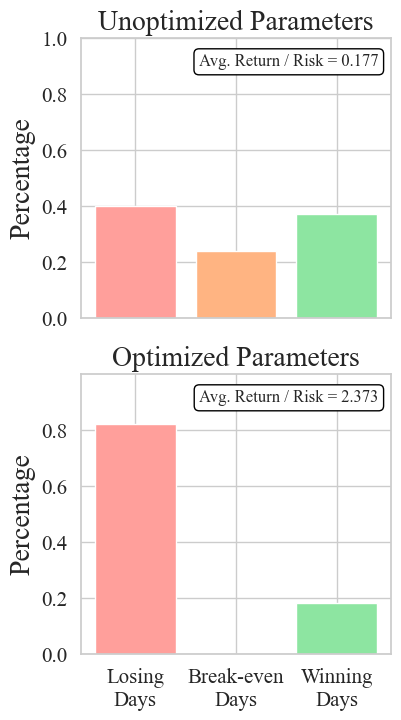

In [102]:
fig, axs = plt.subplots(2, 1, figsize=(4, 8), sharex=True)

red_pastel = sns.color_palette("pastel")[3]
orange_pastel = sns.color_palette("pastel")[1]
green_pastel = sns.color_palette("pastel")[2]
palette = [red_pastel, orange_pastel, green_pastel]

categories = ['Losing\nDays', 'Break-even\nDays', 'Winning\nDays']


axs[0].bar(categories, values_top, color = palette)
axs[1].bar(categories, values_bot, color = palette)

axs[0].set_title('Unoptimized Parameters')
axs[1].set_title('Optimized Parameters')

axs[0].text(0.96, 0.9, f'Avg. Return / Risk = {top_avg_rr}', transform=axs[0].transAxes, fontsize=12, ha='right',
            bbox={'facecolor': 'white', 'edgecolor': 'black', 'boxstyle': 'round'})
axs[1].text(0.96, 0.9, f'Avg. Return / Risk = {bot_avg_rr}', transform=axs[1].transAxes, fontsize=12, ha='right',
            bbox={'facecolor': 'white', 'edgecolor': 'black', 'boxstyle': 'round'})

axs[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8])


xtick_positions = range(len(categories))
xtick_labels = categories

for ax in axs:
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, ha='center')
    ax.set_ylabel('Percentage', fontsize=20)
    ax.set_ylim(0, 1.0)

plt.subplots_adjust(hspace=0.2)
plt.show()

Here is a visual.

### Performance Metric Statistics with Optimized Algorithm

In [75]:
day_num = 2000
starting_balance = 2000

# Parameters
x_percent_loss = -0.02 / 100  # x percent loss threshold
y_percent_gain = 5.0 / 100  # y percent gain threshold
be_threshold = 1.7 / 100 # breakeven threshold
tslp = 1.5 / 100 # trailing stop loss percentage

# Initialize empty lists to store data for each category
avg_daily_return_values = []
avg_yearly_return_values = []
avg_drawdown_values = []
avg_drawdown_duration_values = []
max_drawdown_byper_values = []
max_drawdown_bydur_values = []

categories = [
    "Avg Daily Return",
    "Avg Yearly Return",
    "Avg Drawdown",
    "Avg Drawdown Duration (Days)",
    "Max Drawdown By Percent",
    "Duration of Longest Drawdown (Days)"
]
custom_title = [
    "Avg Daily Return (%)",
    "Avg Yearly Return (%)",
    "Avg Drawdown (%)",
    "Avg Drawdown Duration (Days)",
    "Max Drawdown (%)",
    "Duration of Longest Drawdown (Days)"
]

data_optimized = [[] for i in categories]

# Loop through the random seeds
number_of_sims = 100
seeds = random.sample(range(1, 1000), number_of_sims)
for seed in seeds:
    report = my_algorithm(seed, day_num, starting_balance, x_percent_loss, y_percent_gain, be_threshold, tslp)
    
    # Append data for each category
    for i in range(len(categories)):
        data_optimized[i].append(report[categories[i]])
 

# Create a function to calculate mean, max, min, and values within one standard deviation
def calculate_summary_stats(data):
    mean = np.mean(data)
    max_val = np.max(data)
    min_val = np.min(data)
    std_dev = np.std(data)
    within_std_dev = [x for x in data if mean - std_dev <= x <= mean + std_dev]
    return mean, max_val, min_val, within_std_dev

# Calculate summary statistics for each category
stats_optimized = [calculate_summary_stats(i) for i in data_optimized]

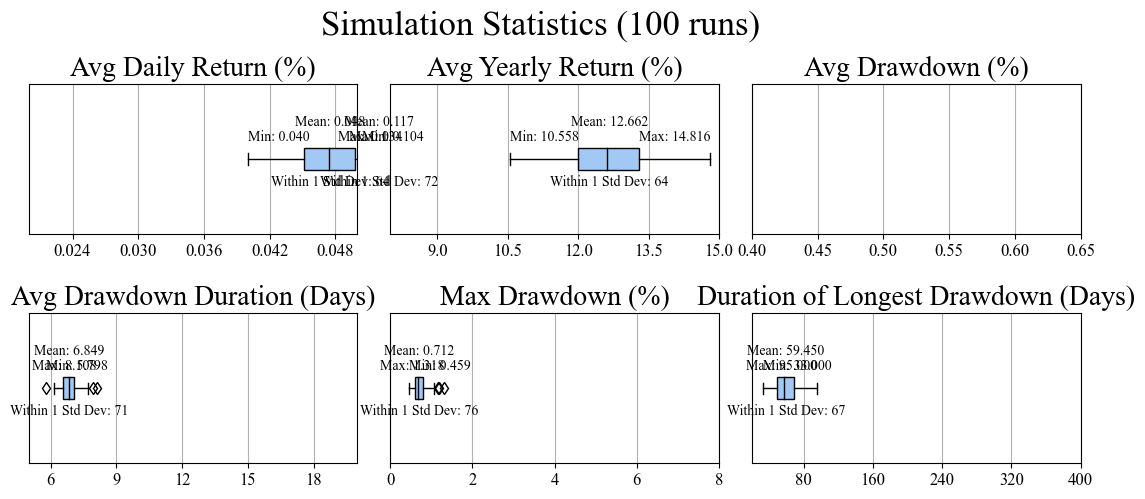

In [77]:
from matplotlib import ticker
import seaborn as sns

nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 2.5*nrows))
fig.tight_layout(pad=3.0)

custom_xlims = [
    (0.02, 0.05),
    (8, 15),
    (0.4, 0.65),
    (5, 20),
    (0, 8),
    (20, 400)
]

for i in range(len(categories)):
    ax = axs.flatten()[i]
    ax.boxplot(data_optimized[i], vert=False, sym="d", 
        boxprops=dict(facecolor=sns.color_palette("pastel")[0]), 
        medianprops=dict(color='black'),
        patch_artist=True)
    ax.set_title(f"{custom_title[i]}")
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.set_xlim(custom_xlims[i])
    ax.grid(True)
    
    # Add statistics text to the plot
    text_color = 'black'
    mean, max_val, min_val, within_std_dev = stats_optimized[i]
    ax.text(mean, 1.25, f"Mean: {mean:.3f}", color=text_color, verticalalignment='center',horizontalalignment='center')
    ax.text(max_val, 1.15, f"Max: {max_val:.3f}", color=text_color, verticalalignment='center', horizontalalignment='right')
    ax.text(min_val, 1.15, f"Min: {min_val:.3f}", color=text_color, verticalalignment='center', horizontalalignment='left')
    ax.text(mean, 0.85, f"Within 1 Std Dev: {len(within_std_dev)}", color=text_color, verticalalignment='center', horizontalalignment='center')

plt.subplots_adjust(wspace=0.1)
fig.suptitle(f"Simulation Statistics ({number_of_sims} runs)", y=1.05, fontsize = 25)
plt.show()

## Conclusion

We used data mining to identify a viable trading strategy, implemented it, and then optimized the parameters of our algorithm using a GA. It turns out that our algorithm was more complicated than necessary, and the optimal strategy revealed by the GA was simply to take losses as quickly as possible and let winning trades run as long as possible. In retrospect, this follows the advice that is common in day trading forums "cut your losses quickly and let your winners run". It's possible that a more volatile asset might benefit from the added saftey rails that the algorithm has, but for the S&P 500 they seem to be more of a hinderance than a benefit. All that being said, the simple approach taking both a long and short position at the start of every day, setting both with a very tight stop loss, and selling everything at the end of the day results in a respectable amount of alpha with minimal drawdowns. 

### Caveats and Future Directions

This little project may not seem like much but it was actually very fun and it took quite a bit of time. I spent most of it learning about genetic algorithms and tweaking my own to improve its efficiency and convergence rate. This was also my first time diping my toe into the world of algorithmic trading (even though nothing actually got implemented in the real world) and I admit that I was thuroughly humbled by just how deep this field is. Now that I'm at the end of this project, if I was to ever do a 2.0 version of it, there are so many more things I would want to consider. 

#### Slippage
Every algorithm needs to have some way of accounting for slippage, which is the difference between the intended execution price and the actual execution price. This can be brought on by order execution delays, lack of liquidity, and super high volatility. The last one especially maters for us given that we depend a lot on volatility (or at least the saftey rails on our algorithm do). As of right now, there is no slippage included in our model and every trade is expected to be executed immediately at the stop loss value. This is probably why the GA ended up having such a small stop loss value, because it allowed for the most extreme version of minimizing drawdown. In reality, even a stop loss of -0.01 % is not always viable. This also leads to the next point

#### Order Book
A more realistic simulation would be to actually use an order book which controls how many buy or sell orders are active at any given time. This would help with simulating slippage, and would also help avoid the GA optimizing for incredibly tiny stop loss values because they would never get filled.

#### Tick Sizes
Stocks do not trade out to the 6th decimal place. They tend to have a set precision that they go to, which for most is $0.01. Again, this also ties back to slippage, but also complicates the phase space of our algorithm. The paramters, which are currently all done in terms of percentages, would need to be converted to dollar amounts with penny precision. Arguably this could be as simple as rounding, but this means that slightly different input parameters will lead to identical outputs, and this can have adverse affects on optimization algorithms.

#### Minute Averages
Using averages was a convienient but pretty rough approximation of true market conditions. It doesn't acount for high volume swings in one direction or another which may cause a position to stop out. The way to address this would either be to encode the range of values more explicitly or trade on smaller timeframes. The later option would require getting more serious about sourcing our historical data, and would also dramatically increase the amount of time the simulation takes to run. If I were to do this project again, I would need to do some more research about how other algorithmic trading strategies take into account entire candles.

#### Other Trading Timeframes
So far we've only exploited the opening of the trading day. The PPC plot on 30 minute and 1 hour timeframes that we made near the beginning showed that there were pretty strong market swings near the end of the day as well (this is not new information, it's just nice to be able to see it myslef). A more sophisticated algorithm might be able to take advantage both of the open and the last 1 hour by using the money from the stopped out position to open up another long-short pair at the 15:00:00 mark. This extra complexity may also lead to a more interesting optimization result.

#### Higher Volatility Tickers
We have focused exclusivley on the S&P 500 for the time being, which is all well and good, but a more volatile asset such as VIX may be able to provide even higher returns. I suspect that the plain old S&P 500 may not really have the necessary daily volatility for this algorithm to cut its teeth on.


### Experimenting with PyGAD for Genetic Algorithms

Mutation is applied after crossover to everything (all children, replicated parents, new random genes, ect) except for the elitism solution

#### Example application, with visualization

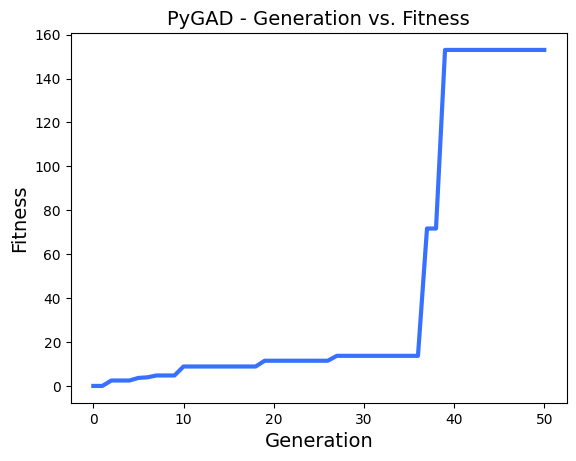

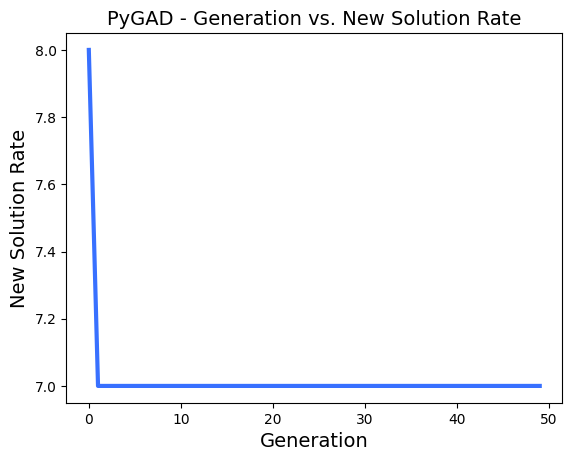

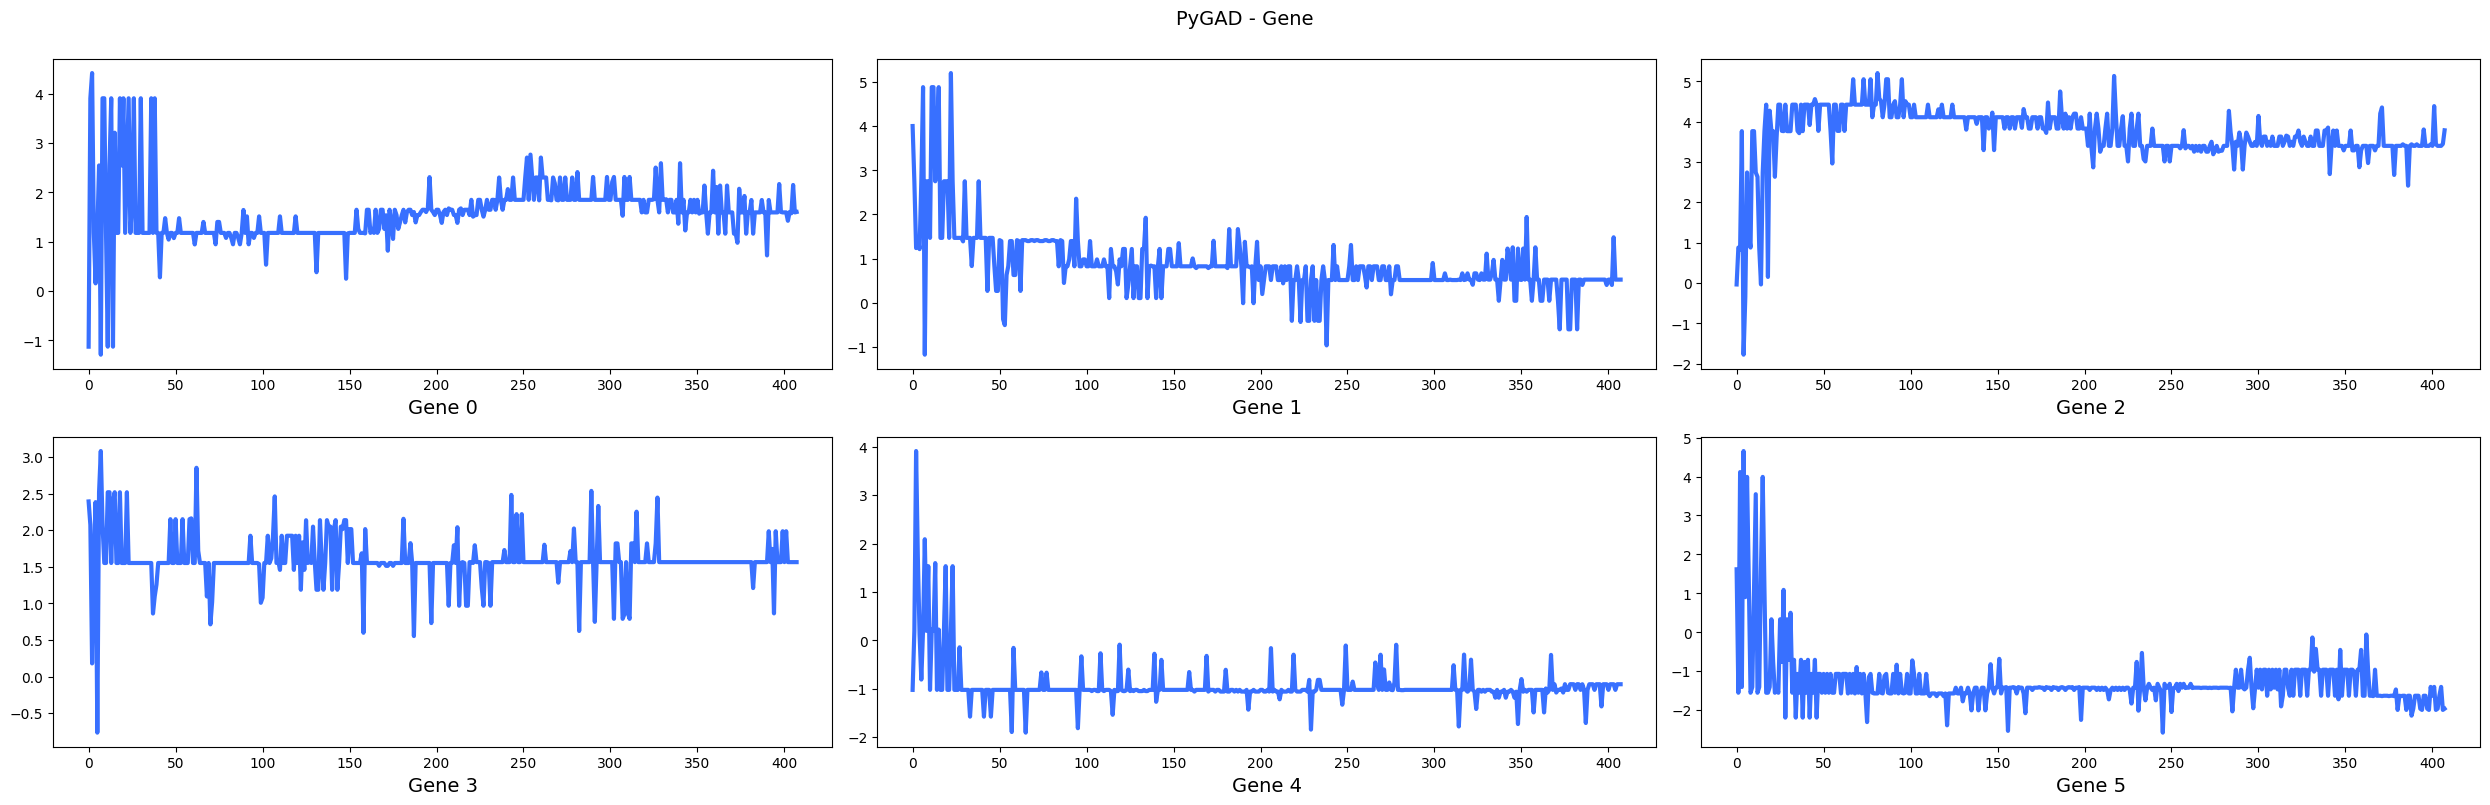

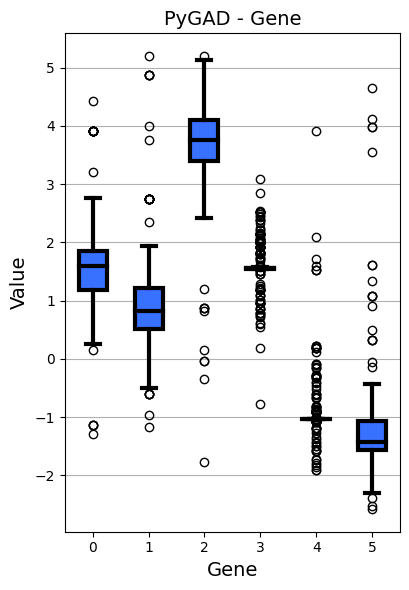

In [102]:
function_inputs = [4,-2,3.5,5,-11,-4.7]
desired_output = 44

def fitness_func(ga_instance, solution, solution_idx):
    output = np.sum(solution*function_inputs)
    fitness = 1.0 / np.abs(output - desired_output)
    return fitness

fitness_function = fitness_func

num_generations = 50
num_parents_mating = 4

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       suppress_warnings=True,
                       mutation_percent_genes=mutation_percent_genes,
                       save_solutions=True)

ga_instance.run()

ga_instance.plot_fitness()
ga_instance.plot_new_solution_rate()
ga_instance.plot_genes()
ga_instance.plot_genes(graph_type="boxplot",
                       solutions='all')
plt.show()

##### My application

In [243]:
ga_instance.run()

-2.7184009858646294 -0.9703933382908108 -0.9989995977858408 0.09356467829596443
-2.2057781460609225 -0.8205428167551185 -0.6251004140085178 0.10361168173645868
-2.6384341301165164 -0.6155989645850162 -0.7882020755281643 0.09957942460504307
-2.906744413902318 -0.8721166297186931 -0.898939675529173 0.0936522441560969
-1.1951233998177222 -0.5978620046662355 -0.8528916461303622 0.1156620657621943
-1.1792340342736702 -0.5602998571531475 -0.9216685544064713 0.11545740978275801
-0.628253858524143 -0.9146803791331842 -0.9998814582602699 0.11705742410876026
-1.3268072369324355 -0.29804618904728175 -0.7882020755281643 0.11886287922631308
2.2662714651671587 0.7579392194367629 0.7321442233518526 0.44570329039379475
1.6197211321563305 -0.707922442659993 -0.8853516482022624 0.16740455921506286
-0.8119202681836806 -0.6381156265017526 -0.8528916461303622 0.12043944681971128
-1.6112928849085537 -0.9551422659218225 -0.9998814582602699 0.10453344174807298
0.6696182905421959 -0.6414910731873782 -0.8853516

KeyboardInterrupt: 

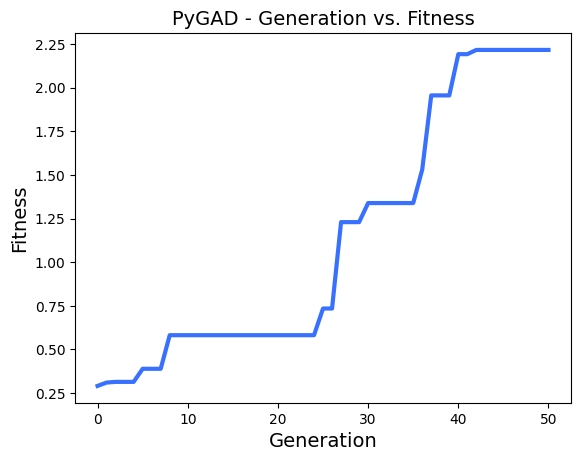

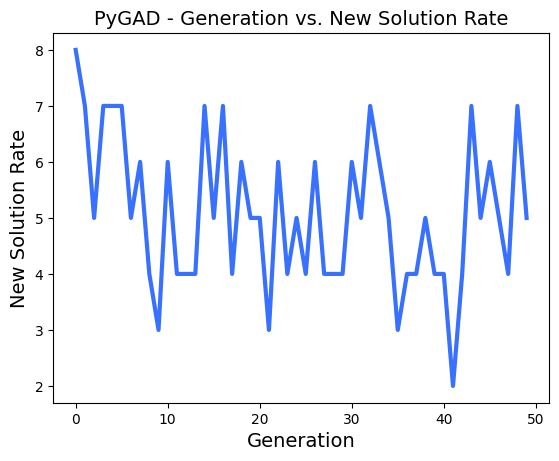

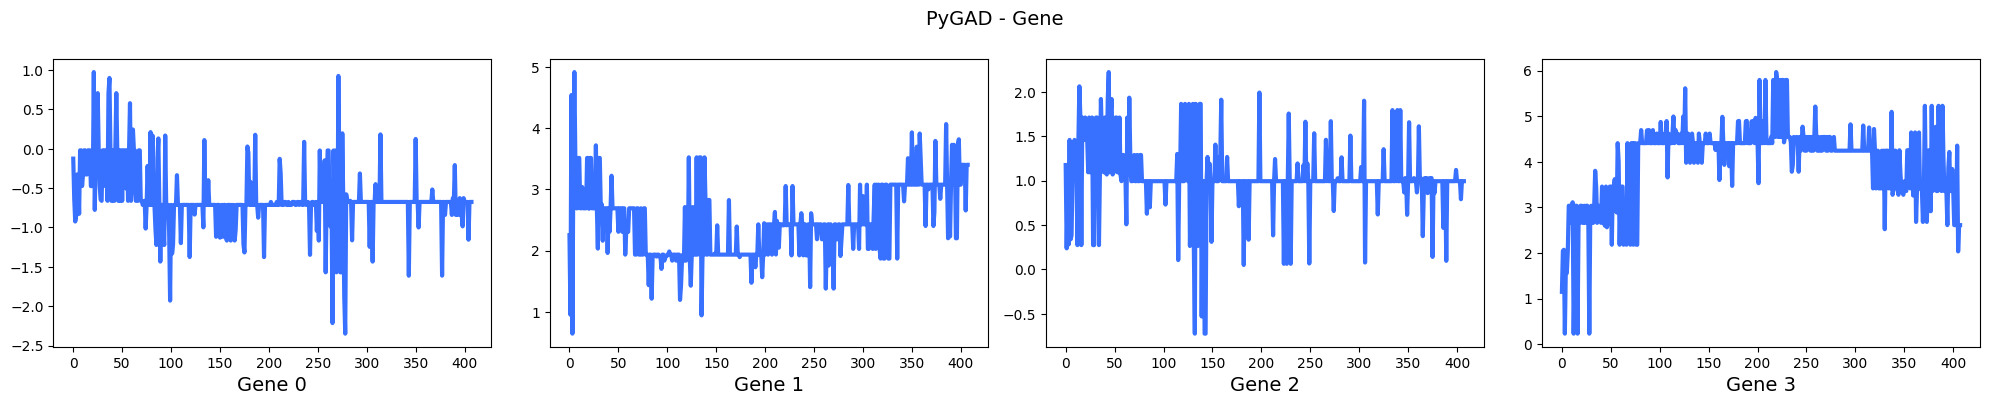

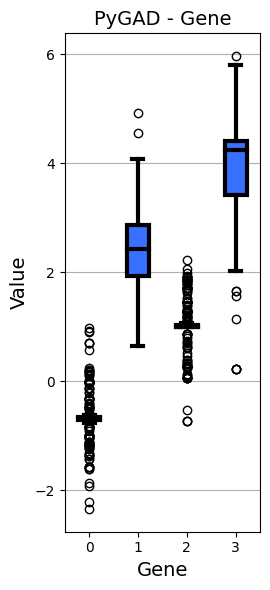

In [ ]:
ga_instance.plot_fitness()
ga_instance.plot_new_solution_rate()
ga_instance.plot_genes()
ga_instance.plot_genes(graph_type="boxplot",
                       solutions='all')
plt.show()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

prediction = np.sum(np.array(function_inputs)*solution)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

Parameters of the best solution : [ 2.95090074 -0.14619581  3.08949676  4.34428243  0.31264707 -0.59757666]
Fitness value of the best solution = 7251.157885600024
Predicted output based on the best solution : 44.00013790900926


## Data Exploration

#### How often is the opening price the high or low for the day?

In [122]:
# Initialize counters
max_opening_price_count = 0
min_opening_price_count = 0

# Iterate through the list of dataframes
for df in market_by_days:
    # Get the opening price for each day
    opening_price = df.iloc[0]['average']
    
    # Find the maximum and minimum values in the "average" column for the day
    max_average = df['average'].max()
    min_average = df['average'].min()
    
    # Check if the opening price is the maximum or minimum for the day
    if opening_price == max_average:
        max_opening_price_count += 1
    elif opening_price == min_average:
        min_opening_price_count += 1

print("Days where opening price is the maximum for the day:", round(max_opening_price_count, 5))
print("Days where opening price is the minimum for the day:", round(min_opening_price_count, 5))
print("Percentage of days where opening price is the maximum for the day:", round(max_opening_price_count / len(market_by_days) * 100, 5))
print("Percentage of days where opening price is the minimum for the day:", round(min_opening_price_count / len(market_by_days) * 100, 5))

Days where opening price is the maximum for the day: 106
Days where opening price is the minimum for the day: 143
Percentage of days where opening price is the maximum for the day: 5.95171
Percentage of days where opening price is the minimum for the day: 8.0292


#### How often does the long or short position hit take profit before stop loss

In [268]:
day_results = []
account_value = 2000

x_percent_loss = -0.2 / 100
y_percent_gain = 2.5 / 100
be_threshold = 10.5 / 100
tslp = 0.5 / 100

# Iterate through the list of dataframes
for df in leveraged_market_by_days:
    
    open_price = df.iloc[0]['3x_lev_average']  # Open position at the first minute's average price

    betting_value = account_value / 2

    long_position = {'open_value': betting_value, 'current_value': betting_value}
    short_position = {'open_value': betting_value, 'current_value': betting_value}

    sl_value = betting_value * (1 + x_percent_loss) # stop-loss value
    tp_value = betting_value * (1 + y_percent_gain) # take-profit value
    be_value = betting_value * (1 + be_threshold)
    final_bet_value = 0
    trailing_sl_triggered = False
    be_value_triggered = False

    debug_msg_arr = []
    #prices = df["average"].tolist()
    prices = df["3x_lev_average"].tolist()
    for current_price in prices:

        if not long_position and not short_position:
            break # break loop once all positions are closed out

        if long_position:
            debug_msg_arr.append(("long_position", round(long_position['current_value'], 5), round(long_position['current_value'] / long_position['open_value'], 5)))
            long_position['current_value'] = (1 + (current_price - open_price) / open_price) * long_position['open_value']
        if short_position:
            debug_msg_arr.append(("short_position", round(short_position['current_value'], 5), round(short_position['current_value'] / short_position['open_value'], 5)))
            short_position['current_value'] = (1 + -1 * (current_price - open_price) / open_price) * short_position['open_value']

        # Check for stop loss condition reached on long position
        if long_position and long_position['current_value'] <= sl_value:
            debug_msg_arr.append(("Stop loss on long_position reached with long value ratio at ", round(long_position['current_value'] / long_position['open_value'], 5)))
            # final_bet_value += long_position['current_value']
            final_bet_value += sl_value # Assume perfect order filling, no slippage
            long_position = None
        # Check for stop loss condition reached on short position
        elif short_position and short_position['current_value'] <= sl_value:
            debug_msg_arr.append(("Stop loss on short_position reached with short value ratio at ", round(short_position['current_value'] / short_position['open_value'], 5)))
            # final_bet_value += short_position['current_value']
            final_bet_value += sl_value # Assume perfect order filling, no slippage
            short_position = None


        # Trailing stop loss management
        if not trailing_sl_triggered:
            # Check for trailing stop condition reached on long position
            if long_position and long_position['current_value'] >= tp_value:
                debug_msg_arr.append(("Trigging trailing stop loss on long at ", round(long_position['current_value'] / long_position['open_value'], 5)))
                sl_value = long_position['current_value'] * (1 - tslp)
                debug_msg_arr.append(("Setting sl_value to ", round(sl_value, 5), "relative to ", round(long_position['current_value'], 5)))
                trailing_sl_triggered = True
            # Check for trailing stop condition reached on short position
            elif short_position and short_position['current_value'] >= tp_value:
                debug_msg_arr.append(("Trigging trailing stop loss on short at ", round(short_position['current_value'] / short_position['open_value'], 5)))
                sl_value = short_position['current_value'] * (1 - tslp)
                debug_msg_arr.append(("Setting sl_value to ", round(sl_value, 5), "relative to ", round(short_position['current_value'], 5)))
                trailing_sl_triggered = True
        else:
            if long_position and sl_value < long_position['current_value'] * (1 - tslp):
                sl_value = long_position['current_value'] * (1 - tslp)
                debug_msg_arr.append(("Updating trailing stop loss to", round(sl_value, 5), "with long at", round(long_position['current_value'], 5)))
            elif short_position and sl_value < short_position['current_value'] * (1 - tslp):
                sl_value = short_position['current_value'] * (1 - tslp)
                debug_msg_arr.append(("Updating trailing stop loss to", round(sl_value, 5), "with short at", round(short_position['current_value'], 5)))

        # Condition for moving sl_value to breakeven after one of the positions has stopped out
        if be_value_triggered == False:
            if long_position is not None and short_position is None and long_position['current_value'] >= be_value:
                debug_msg_arr.append(("be_value on long_position reached with short at ", round(long_position['current_value'] / long_position['open_value'], 5)))
                sl_value = betting_value * (1 + -1 * x_percent_loss)
                be_value_triggered = True
            if short_position is not None and long_position is None and short_position['current_value'] >= be_value:
                debug_msg_arr.append(("be_value on short_position reached with short at ", round(short_position['current_value'] / short_position['open_value'], 5)))
                sl_value = betting_value * (1 + -1 * x_percent_loss)
                be_value_triggered = True

    # Close any remaining positions at the end of the day
    if long_position:
        debug_msg_arr.append(("Closing long position at ", long_position['current_value']))
        final_bet_value += long_position['current_value']
    if short_position:
        debug_msg_arr.append(("Closing short position at ", short_position['current_value']))
        final_bet_value += short_position['current_value']
    
    if round(final_bet_value, 6) > round(account_value, 6):
        day_results.append(2)
    elif round(final_bet_value, 6) == round(account_value, 6):
        day_results.append(1)
    else:
        day_results.append(0)

# Count the occurrences of each number
count_0 = day_results.count(0)
count_1 = day_results.count(1)
count_2 = day_results.count(2)

# Print the results
print(f"Number of losing days (0's): {count_0}")
print(f"Number of break-even days (1's): {count_1}")
print(f"Number of winning days (2's): {count_2}")

Number of losing days (0's): 2251
Number of break-even days (1's): 0
Number of winning days (2's): 1041


#### Plotting the first day of prices

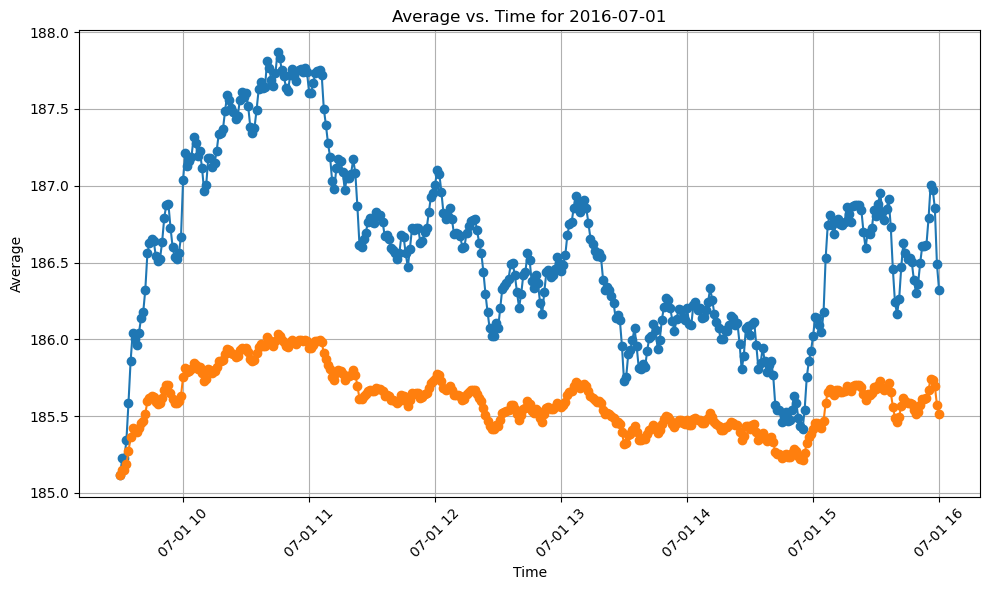

In [109]:
day = leveraged_market_by_days[0]    
plt.figure(figsize=(10, 6))
plt.plot(day.index, day['3x_lev_average'], marker='o', linestyle='-')
plt.plot(day.index, day['average'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Average')
plt.title('Average vs. Time for ' + str(market_df.index[0].date()))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### 10 random market days plotted

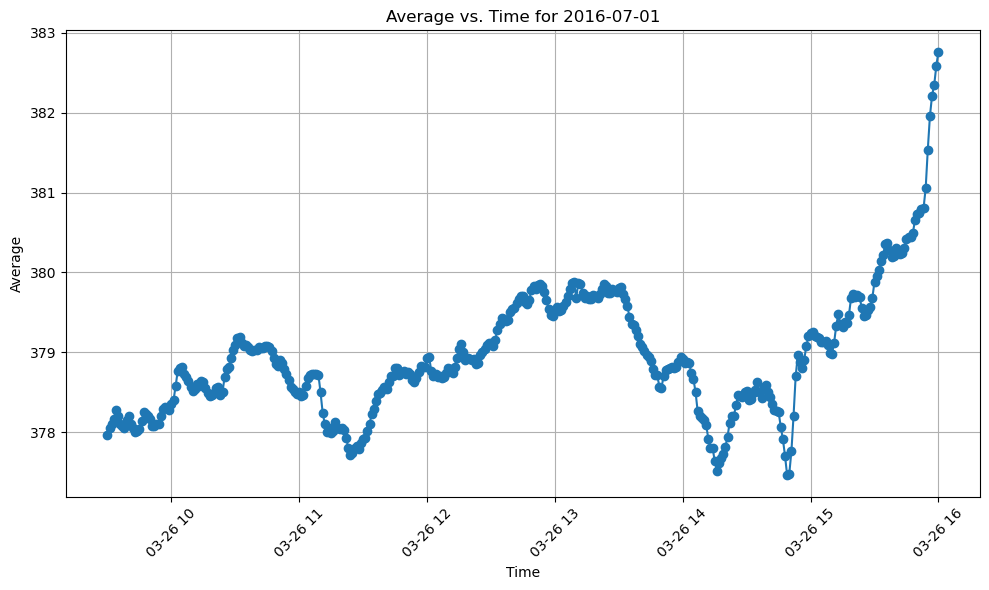

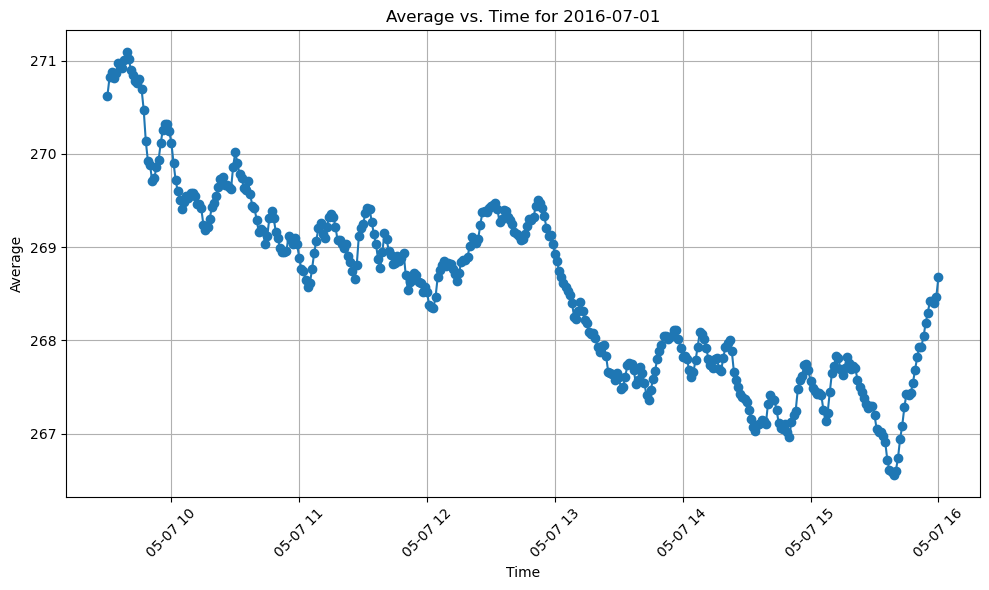

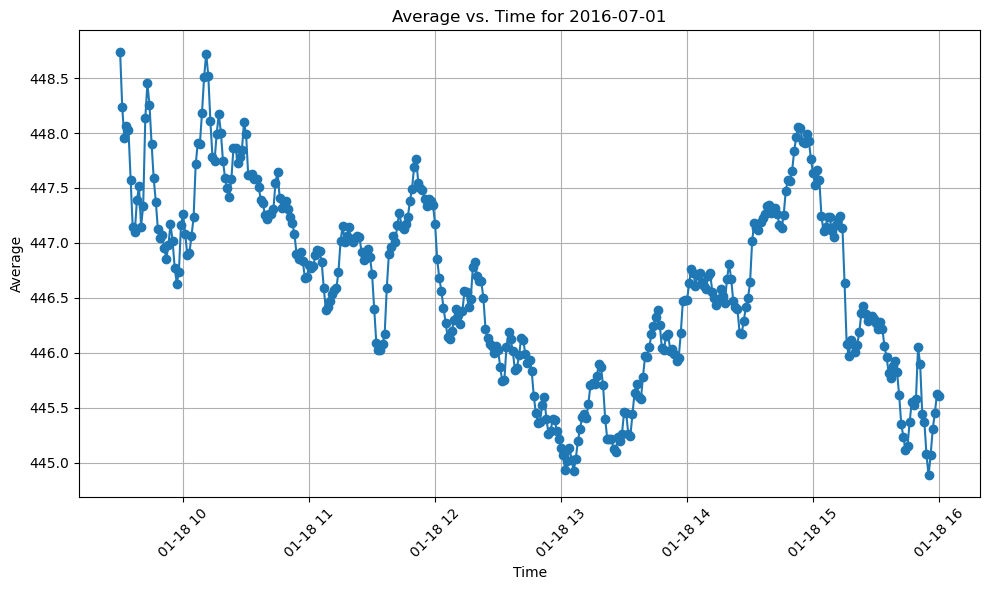

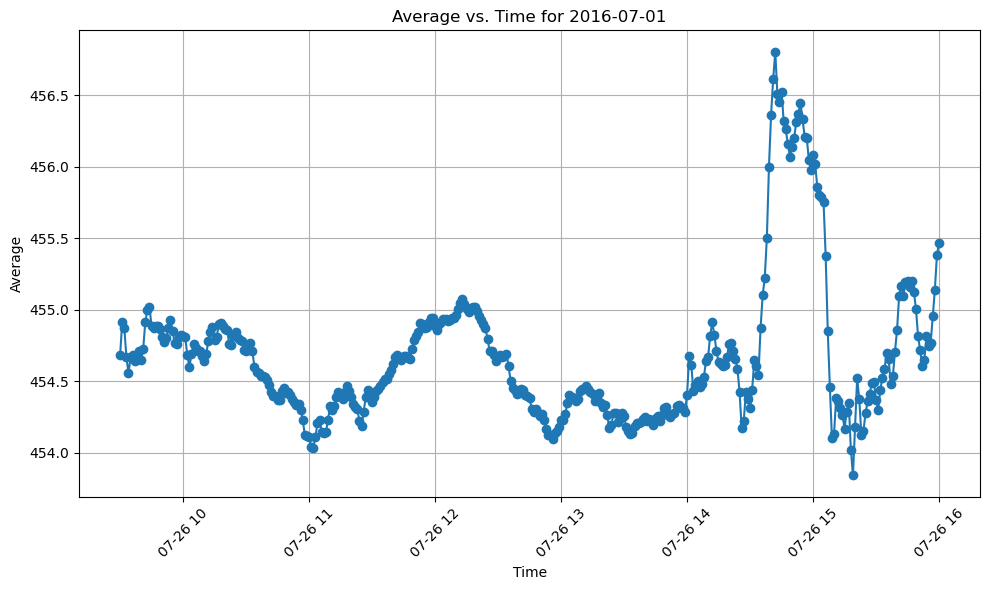

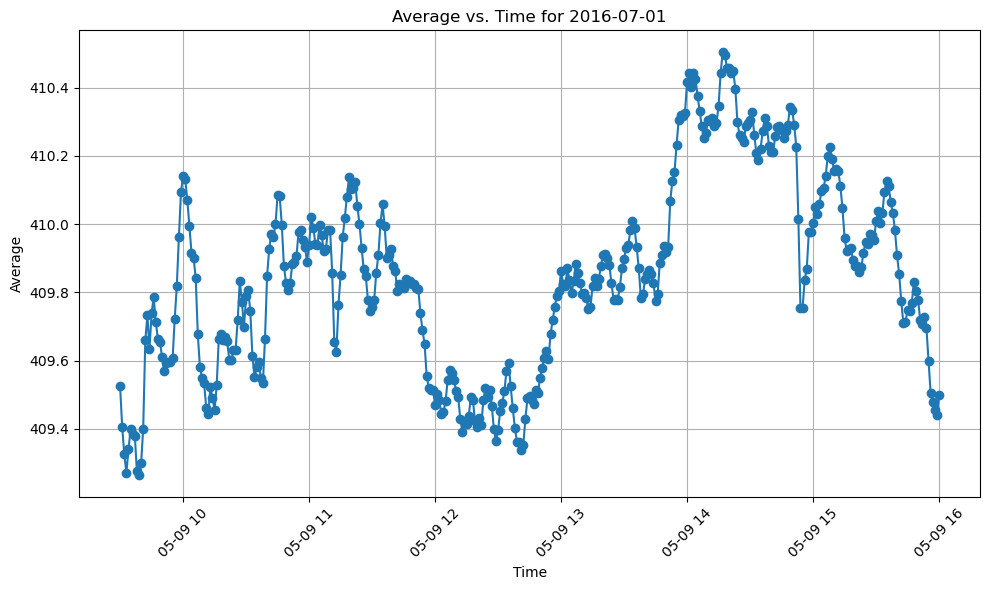

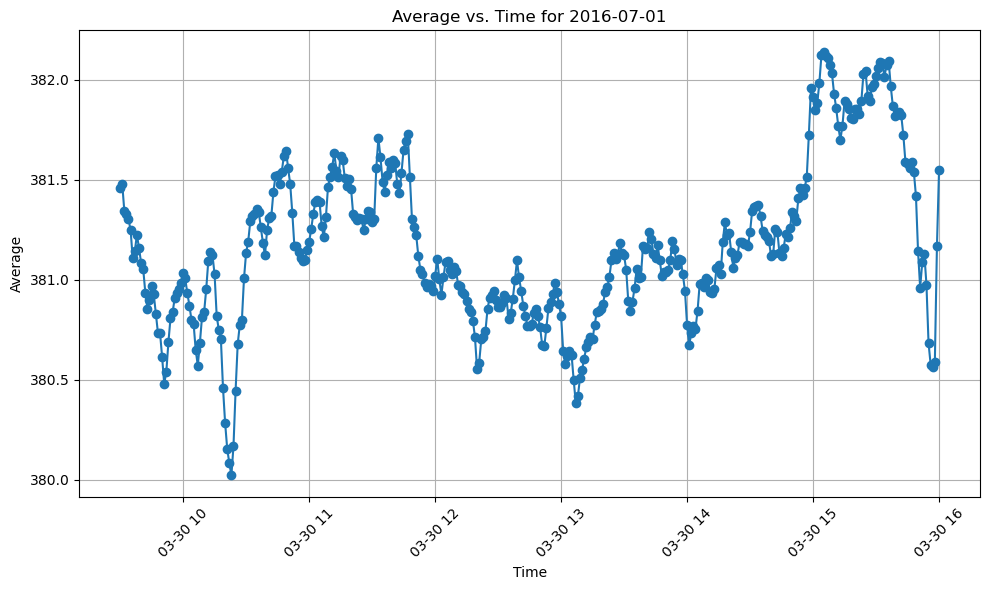

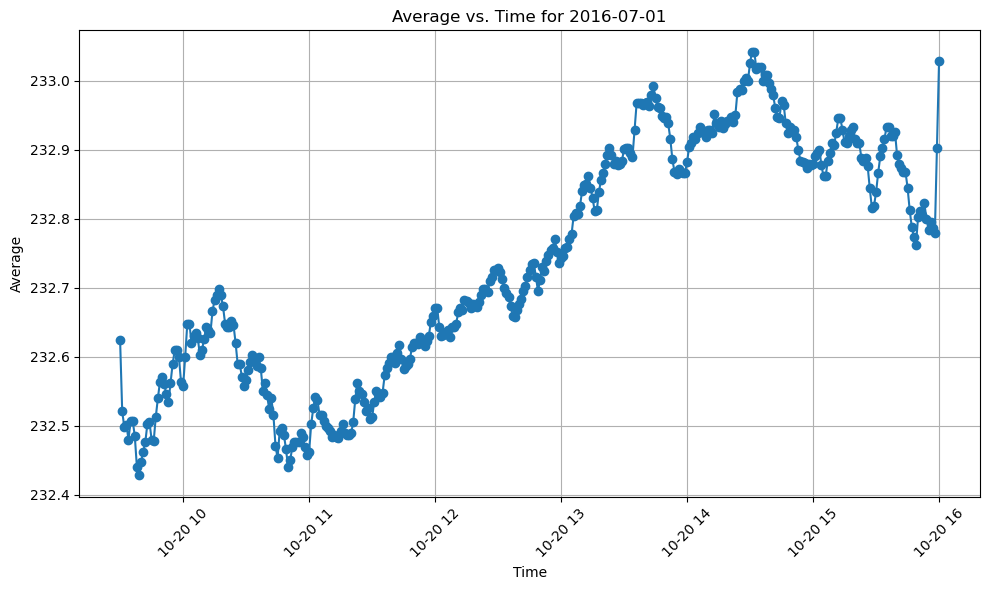

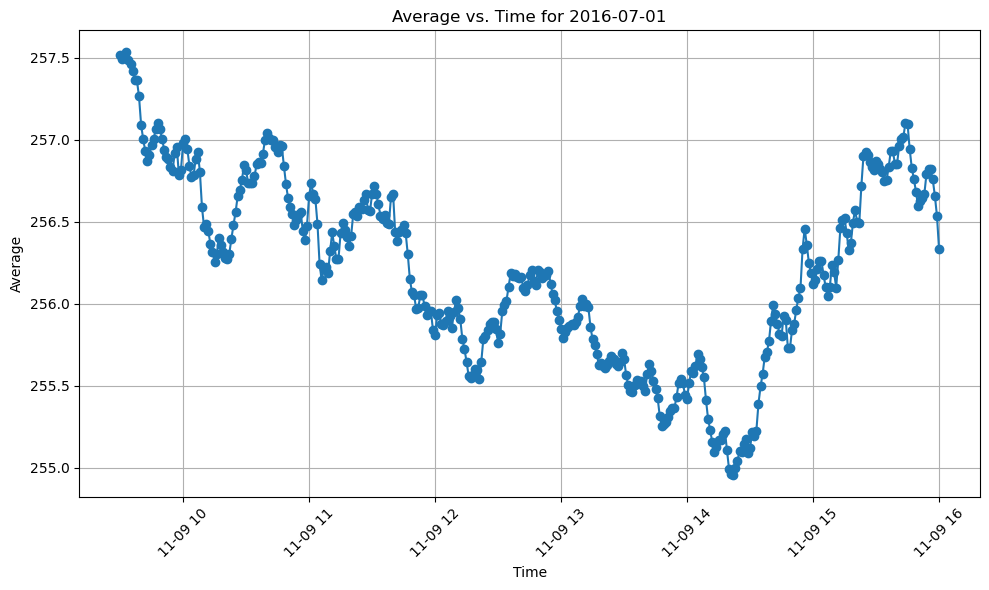

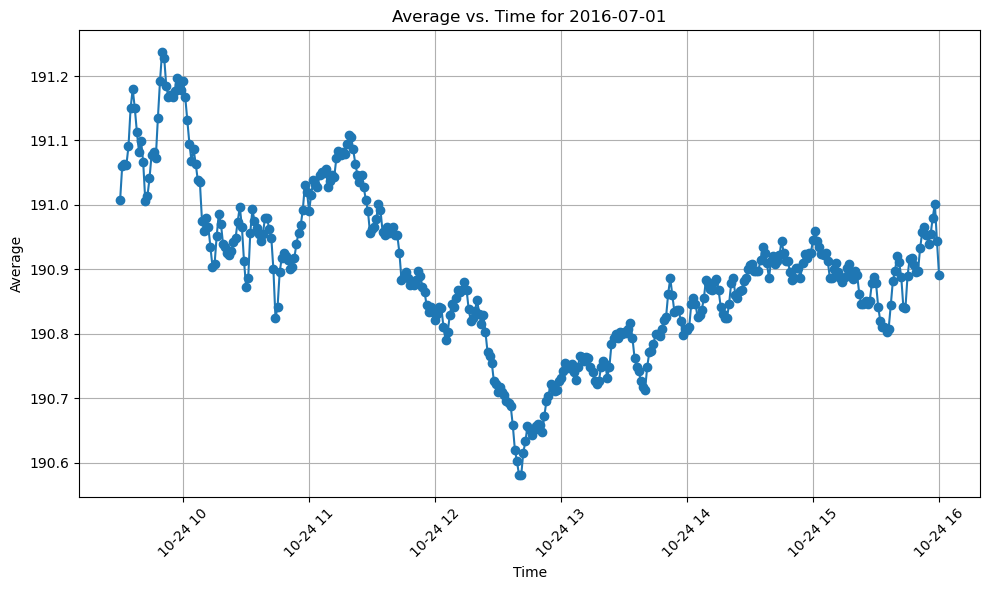

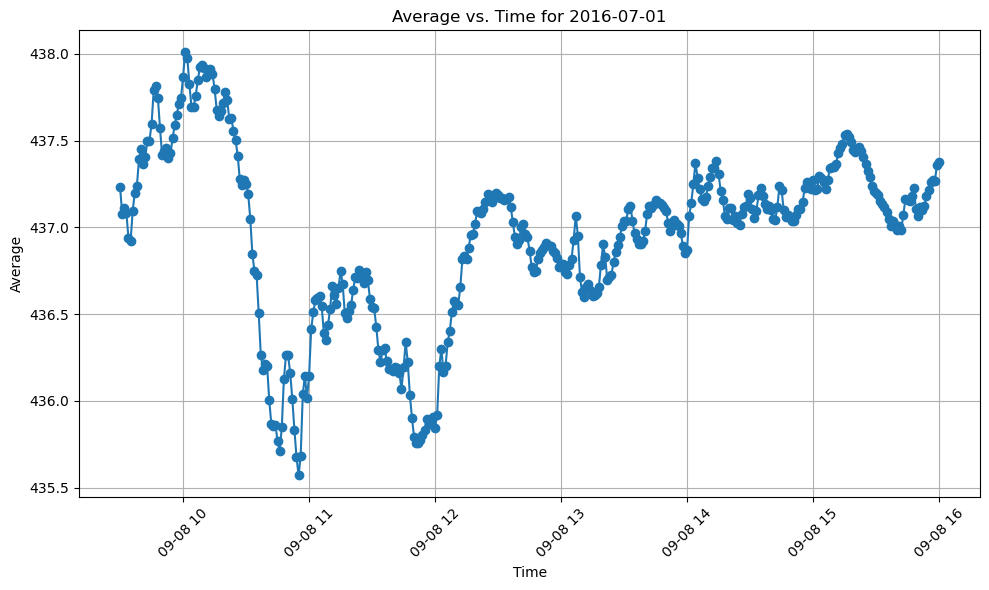

In [356]:
for day in random.sample(market_by_days, 10):
    
    plt.figure(figsize=(10, 6))
    plt.plot(day.index, day['average'], marker='o', linestyle='-')
    plt.xlabel('Time')
    plt.ylabel('Average')
    plt.title('Average vs. Time for ' + str(market_df.index[0].date()))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Mining and Feature Selection

In [224]:
trading_days = []
for date in market_df.index.date:
    if date not in trading_days:
        trading_days.append(date)

# Sort dataframe into trading days
market_by_days = [market_df[market_df.index.date == date] for date in trading_days]

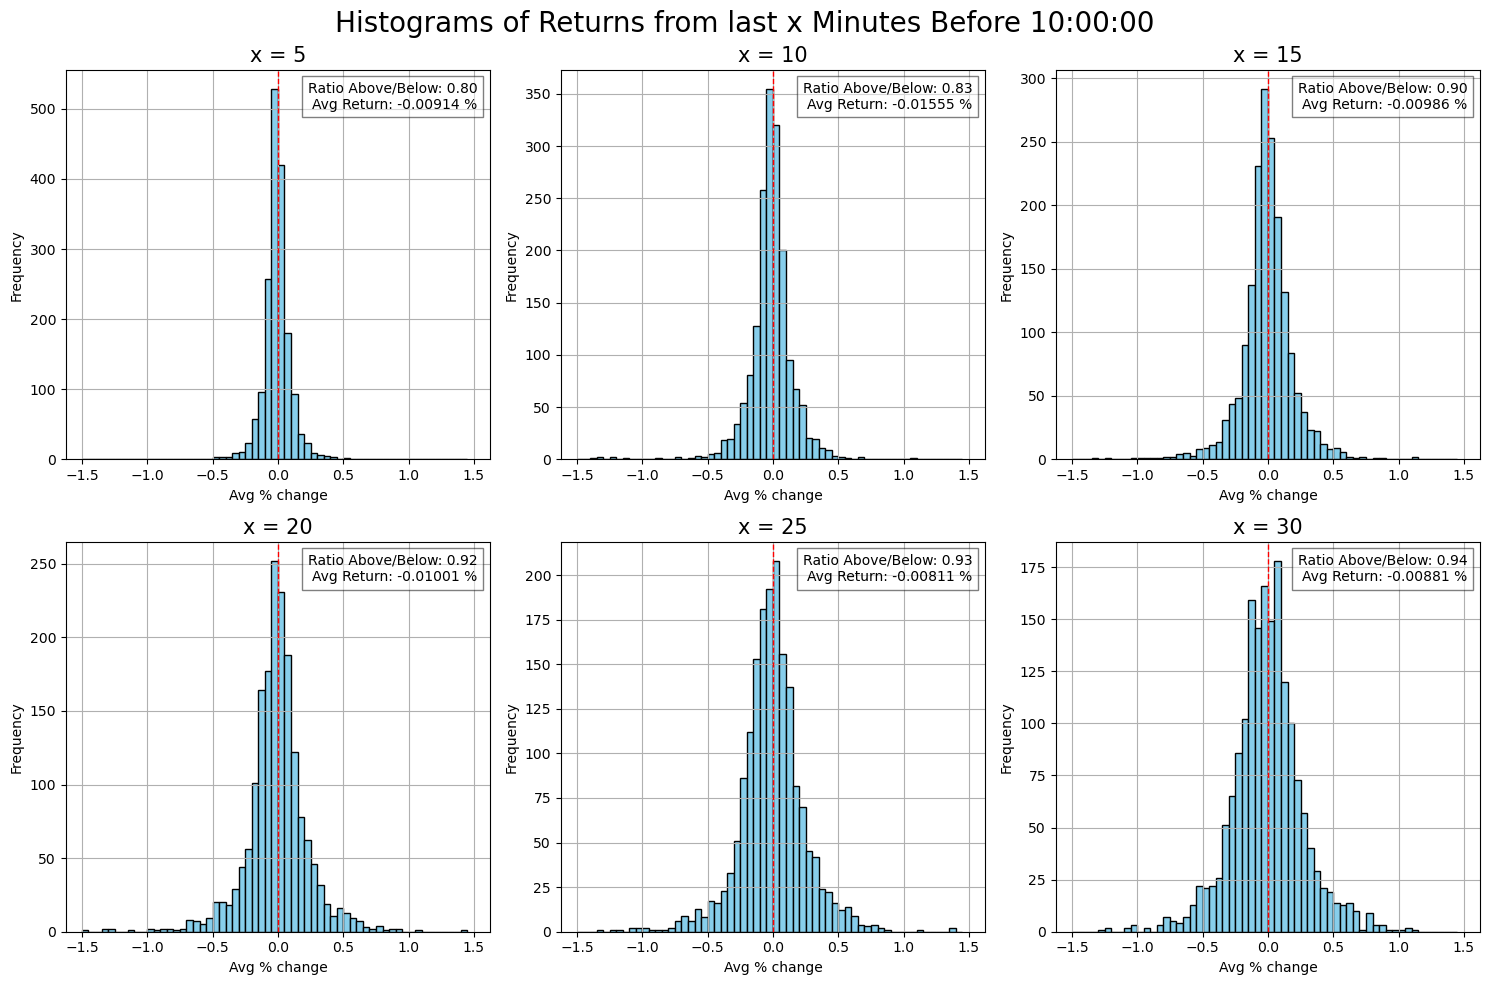

In [375]:
def x_min_trend(subset_df, x_min_start, x_min_stop):
    temp = subset_df.between_time(x_min_start, x_min_stop, inclusive="both")["average"].values.tolist()
    return (temp[0] - temp[-1]) / temp[0] * 100

last_x_min_trends = []
# x_mins = [6,8,10,12,14,16]
x_mins = [5,10,15,20,25,30]
x_min_stop = "10:00:00"

for x_min in x_mins:
    x_min_start = (pd.to_datetime(x_min_stop) - pd.DateOffset(minutes=x_min)).time()
    temp = []
    for key, df in enumerate(market_by_days):
        try:
            temp.append(x_min_trend(df, x_min_start=x_min_start, x_min_stop=x_min_stop))
        except:
            pass # For some reason, no data for this candle
    last_x_min_trends.append(temp)

# Create a 2x3 grid of subplots for each x_min
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle(f"Histograms of Returns from last x Minutes Before {str(x_min_stop)}", fontsize=20)

bins = np.arange(-1.5, 1.5, 0.05)
# Plot histograms for each x_min in a separate subplot
for idx, x_min in enumerate(x_mins):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    hist_vals, bins, _ = ax.hist(last_x_min_trends[idx], bins=bins, color='skyblue', edgecolor='black')
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    above_zero = sum(val > 0 for val in last_x_min_trends[idx])
    below_zero = sum(val < 0 for val in last_x_min_trends[idx])
    ratio = above_zero / below_zero

    avg_ppc = np.asarray(last_x_min_trends[idx]).mean()
    ax.text(0.97, 0.97, f"Ratio Above/Below: {ratio:.2f}\nAvg Return: {avg_ppc:.5f} %", transform=ax.transAxes, 
        ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    ax.set_title(f"x = {x_min}", fontsize=15)
    ax.set_xlabel('Avg % change')
    ax.set_ylabel('Frequency')
    ax.axvline(x=0, color='red', linestyle='dashed', linewidth=1)
    ax.set_xlim(-np.max(np.abs(bin_centers))*1.1, np.max(np.abs(bin_centers))*1.1)
    ax.grid(True)

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Show the plot
plt.show()

In [186]:
def x_min_trend(subset_df, x_min_start, x_min_stop):
    temp = subset_df.between_time(x_min_start, x_min_stop, inclusive="both")["average"].values.tolist()
    return (temp[0] - temp[-1]) / temp[0] * 100

x_mins = [6,8,10,12,14,16]

arr = [[],[],[]]
X_MIN_STOP = "16:00:00"
for i in np.arange(0, 374.1, 2):
    x_min_stop = (pd.to_datetime(X_MIN_STOP) - pd.DateOffset(minutes=i)).time()
    arr[0].append(x_min_stop)
    avg_ppc = []
    for x_min in x_mins:
        x_min_start = (pd.to_datetime(str(x_min_stop)) - pd.DateOffset(minutes=x_min)).time()
        temp = []
        for df in market_by_days:
            try:
                temp.append(x_min_trend(df, x_min_start=x_min_start, x_min_stop=x_min_stop))
            except:
                pass # For some reason, no data for this candle
        avg_ppc.append(round(np.asarray(temp).mean(),5))
    
    arr[1].append(max(avg_ppc))
    arr[2].append(min(avg_ppc))

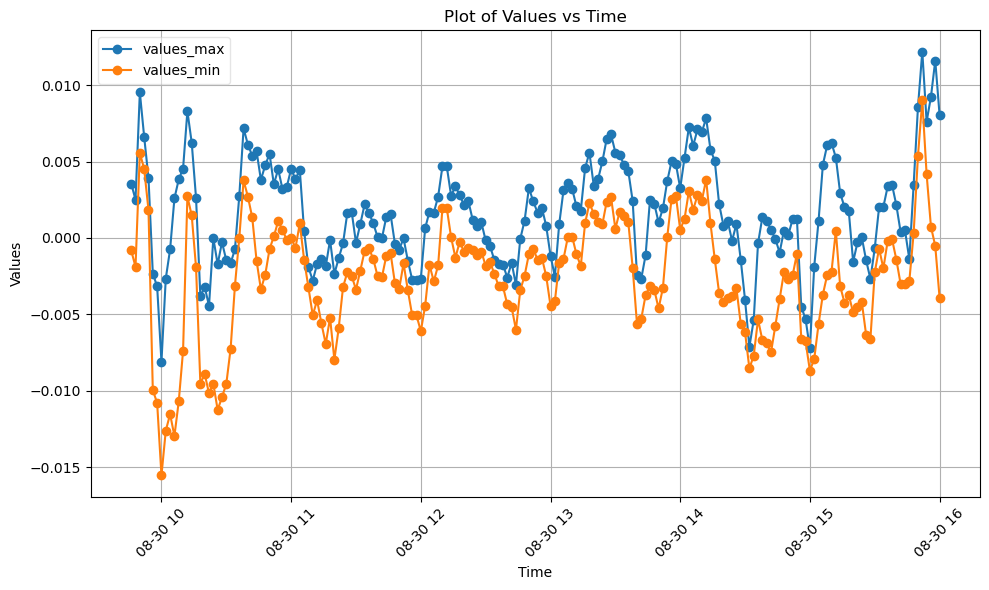

In [187]:
from datetime import datetime

# Extract time values and numerical values
times = arr[0]
values_max = arr[1]
values_min = arr[2]

# Convert time values to a common date to make them usable in plotting
common_date = datetime.today().date()  # You can use any date here

# Convert time values to datetime objects
time_datetimes = [datetime.combine(common_date, t) for t in times]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_datetimes, values_max, marker='o', label = "values_max")
plt.plot(time_datetimes, values_min, marker='o', label = "values_min")
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Plot of Values vs Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(fancybox=True, framealpha=0.5)
plt.tight_layout()
plt.show()

### Feature Isolation for PCA

In [449]:
# List of potential features
# [gap_ppc, 
# first_{60, 120, 180, 240, 300, 360}_min_ppc, 
# last_{5, 15, 30, 60, 120, 180}_min_ppc_before_roi,
# volume up to that point in the day,
# std_deviation (aross data before last x minutes)
# maximum_drawdown (np.max - np.min),
# integral of data - SMA 12]

# target_entry_time = "09:56:00"
# target_exit_time = "10:00:00"

# target_entry_time = "15:50:00"
# target_exit_time = "15:58:00"
target_entry_time = "09:50:00"
target_exit_time = "10:00:00"

X = []
Y = []
for key, df in enumerate(market_by_days):
    if key == 0:
        pass # Skip the first day
    else:
        today_df = df.between_time("09:30:00", target_entry_time)
        time_diff = pd.to_datetime(target_entry_time) - pd.to_datetime("09:30:00")
        if len(today_df.index) == round(time_diff.total_seconds() / 60) + 1:
            
            # Making feature list
            today_df = df.between_time("09:30:00", target_entry_time)
            yesterday_df = market_by_days[key-1]

            yesterday_close = yesterday_df.iloc[-1]['average']
            today_open = today_df.iloc[0]['average']
            
            gap_ppc = (today_open - yesterday_close) / today_open * 100

            total_volume = today_df['volume'].sum()
            
            five_min_before = (pd.to_datetime(target_entry_time) - pd.DateOffset(minutes=5)).time()
            last_five_min_df = today_df.between_time(five_min_before, target_entry_time)
            last_five_min_volume = last_five_min_df['volume'].sum()
            last_five_min_trend = (last_five_min_df.iloc[0]['average'] - last_five_min_df.iloc[-1]['average']) / last_five_min_df.iloc[0]['average'] * 100

            ten_min_before = (pd.to_datetime(target_entry_time) - pd.DateOffset(minutes=10)).time()
            last_ten_min_df = today_df.between_time(ten_min_before, target_entry_time)
            last_ten_min_volume = last_ten_min_df['volume'].sum()
            last_ten_min_trend = (last_ten_min_df.iloc[0]['average'] - last_ten_min_df.iloc[-1]['average']) / last_ten_min_df.iloc[0]['average'] * 100

            std_deviation = today_df['average'].std()
            max_avg_drawdown = (today_df['average'].max() - today_df['average'].min()) / today_df['average'].max()
            max_true_drawdown = (today_df['high'].max() - today_df['low'].min()) / today_df['high'].max() * 100

            # daily_features = [
            #     gap_ppc, total_volume, 
            #     last_five_min_volume, last_five_min_trend, 
            #     last_ten_min_volume, last_ten_min_trend,
            #     std_deviation, max_avg_drawdown, max_true_drawdown
            #     ]
            daily_features = [
                gap_ppc, max_avg_drawdown, max_true_drawdown, std_deviation, last_five_min_trend, last_ten_min_trend
                ]
            # daily_features = last_ten_min_df['average'].values.tolist()
            # daily_features = [(daily_features[0] - i) / daily_features[0] for i in daily_features[1:]]
            X.append(daily_features)

            # Making target list
            today_df = df.between_time(target_entry_time, target_exit_time)
            last_x_min_price = today_df.iloc[0]['average']
            closing_price = today_df.iloc[-1]['average']
            percent_change = (last_x_min_price -  closing_price) / last_x_min_price * 100
            if percent_change > 0.2:
            #     Y.append(1)
            #     X[-1] = X[-1]
            # else:
            #     Y.append(0)
            #     X[-1] = X[-1]
            #     Y.append(1)
            #     X[-1] = X[-1] + [percent_change]
            # else:
            #     Y.append(0)
            #     X[-1] = X[-1] + [percent_change]
                Y.append(1)
                X[-1] = X[-1] + [1]
            else:
                Y.append(0)
                X[-1] = X[-1] + [0]
        
        else:
            pass

print(Y.count(1) / len(Y))

X = np.asarray(X)
Y = np.asarray(Y)

0.06925675675675676


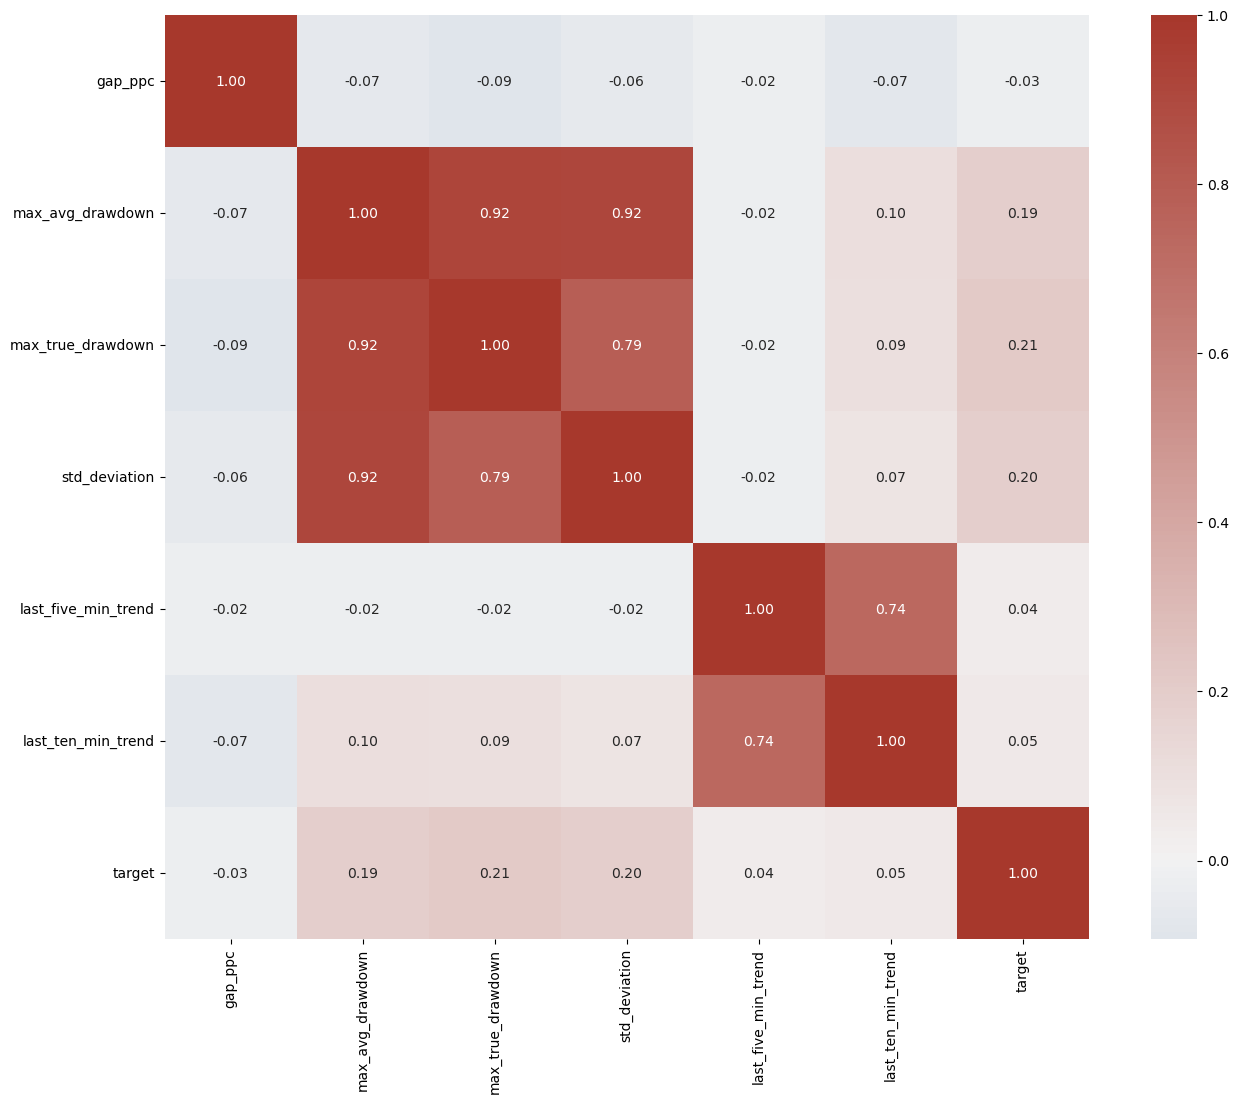

In [450]:
import seaborn as sns
temp = pd.DataFrame(X, columns=["gap_ppc", "max_avg_drawdown", "max_true_drawdown", 
"std_deviation", "last_five_min_trend", "last_ten_min_trend", "target"])
# temp = pd.DataFrame(X, columns=["gap_ppc", "max_avg_drawdown", "max_true_drawdown", 
# "std_deviation", "last_five_min_trend", "last_ten_min_trend"])

plt.figure(figsize=(16,12))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

_ = sns.heatmap(temp.corr(), center=0, annot=True, 
                fmt='.2f', square=True, cmap=cmap)

### Preprocess features

In [420]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

print(X[0:5])
print(X_scaled[0:5])

[[-0.43744485  0.0035347   0.58928793  0.21135584  0.11882413  0.23466291]
 [-0.33161987  0.00280196  0.54874007  0.14844779 -0.0671086  -0.0032715 ]
 [ 0.12287396  0.00299816  0.53877402  0.14673978 -0.09519353 -0.14043357]
 [ 0.72267583  0.00260118  0.47690589  0.14204503 -0.08570908 -0.14686649]
 [ 0.30027162  0.00170535  0.41739406  0.0785391   0.05191503  0.02596425]]
[[-0.70981193  0.2963183   0.39042693 -0.25538312  0.9667781   1.2640264 ]
 [-0.55567586 -0.01616057  0.25188349 -0.51649171 -0.6294826  -0.05188345]
 [ 0.10630298  0.06751117  0.21783161 -0.52358107 -0.870596   -0.81046609]
 [ 0.97992572 -0.10178163  0.00644134 -0.54306727 -0.78917055 -0.84604374]
 [ 0.36468603 -0.48381472 -0.19689791 -0.80665746  0.39235332  0.10980657]]


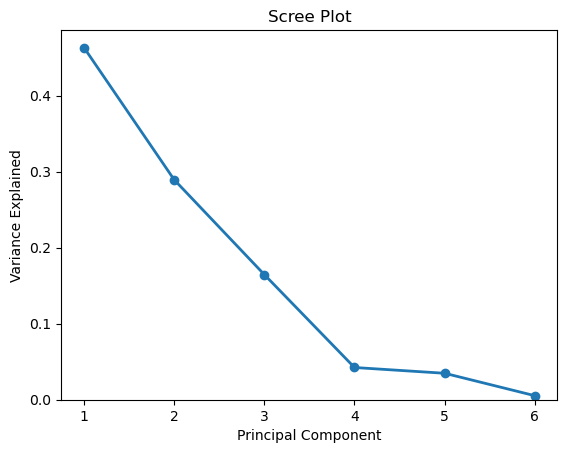

In [421]:
from sklearn.decomposition import PCA

n_compnents = len(X[0])

pca = PCA(n_components=n_compnents, whiten=True)
pca.fit(X_scaled)
X_PCA = pca.transform(X)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(np.arange(1, n_compnents+0.1, 1))
plt.ylim(0,None)
plt.show()

In [422]:
print(pca.components_)

[[-0.0732174   0.59154014  0.5649374   0.56158423  0.01934145  0.09906699]
 [ 0.07683527  0.04909426  0.0468711   0.0585286  -0.70686919 -0.6974235 ]
 [ 0.99309557  0.04991265  0.01101946  0.05670325  0.08158854  0.03572869]
 [ 0.04148661  0.00275555  0.09875615 -0.19516064 -0.68719001  0.69152057]
 [ 0.02456241  0.01618346  0.69312667 -0.68912039  0.14327969 -0.15262443]
 [ 0.013126   -0.80306242  0.43399313  0.40621141 -0.02336618  0.03185488]]


#### PCA Plot

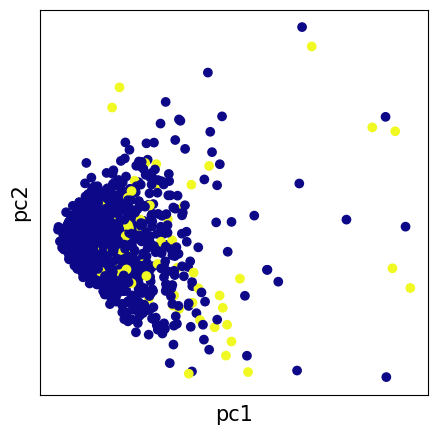

In [423]:
plt.figure(figsize=(5,5))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=Y, cmap='plasma')
plt.xlabel('pc1', fontsize=15)
plt.ylabel('pc2', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.show()

In [424]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.5, random_state = 9)
x_train, x_test, y_train, y_test = train_test_split(X_PCA, Y, test_size= 0.2, random_state = 1)

model = LogisticRegression(solver='lbfgs')
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

print(y_train[0:200])
print(model.predict(x_train[0:200]))
print(y_test[0:200])
print(model.predict(x_test[0:200]))

print("\nError")
print(mean_absolute_error(y_test, model.predict(x_test)))

0.9647887323943662
0.9578651685393258
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### Input: All ppc_from_open for first 60 minutes

In [170]:
first_x_min = 60 # minutes
last_x_min = 5 # minutes
X = []
Y = []

for date in trading_days:
    subset_df = market_df[market_df.index.date == date]

    last_x_min_price = subset_df.iloc[-last_x_min]['average']
    closing_price = subset_df.iloc[-1]['average']
    Y.append((last_x_min_price -  closing_price) / last_x_min_price * 100)

    X.append(subset_df['ppc_from_open'].values.tolist()[1:first_x_min])

X_SCALING_FACTOR = np.abs(np.max(X))
Y_SCALING_FACTOR = np.abs(np.max(Y))

X = X / X_SCALING_FACTOR
Y = Y / Y_SCALING_FACTOR

### Input: All ppc_from_open for first 60 minutes, averaged to every 10 minutes

In [53]:
first_x_min = 60 # minutes
last_x_min = 60 # minutes
X = []
Y = []

for date in trading_days:
    subset_df = market_df[market_df.index.date == date]

    last_x_min_price = subset_df.iloc[-last_x_min]['average']
    closing_price = subset_df.iloc[-1]['average']
    Y.append((last_x_min_price -  closing_price) / last_x_min_price * 100)

    temp = np.asarray(subset_df['ppc_from_open'].values.tolist()[1:first_x_min+1])
    window_size = 10
    temp = np.mean(temp.reshape(-1, window_size), axis=1)
    X.append(temp)

X_SCALING_FACTOR = np.abs(np.max(X))
Y_SCALING_FACTOR = np.abs(np.max(Y))

X = X / X_SCALING_FACTOR
Y = Y / Y_SCALING_FACTOR

### Input: ppc from open to first 60 min average price

In [119]:
first_x_min = 60 # minutes
last_x_min = 60 # minutes
X = []
Y = []

for date in trading_days:
    subset_df = market_df[market_df.index.date == date]

    last_x_min_price = subset_df.iloc[-last_x_min]['average']
    closing_price = subset_df.iloc[-1]['average']
    Y.append((last_x_min_price -  closing_price) / last_x_min_price * 100)

    first_x_min_ppc = subset_df['ppc_from_open'].values.tolist()[first_x_min]
    X.append([first_x_min_ppc])

X_SCALING_FACTOR = np.abs(np.max(X))
Y_SCALING_FACTOR = np.abs(np.max(Y))

X = X / X_SCALING_FACTOR
Y = Y / Y_SCALING_FACTOR

### Input: Percent Point change from previous day close (Gap)

In [130]:
last_x_min = 60 # minutes
X = []
Y = []

for key, date in enumerate(trading_days):
    if key == 0:
        pass # Skip the first day
    else:
        today_df = market_df[market_df.index.date == date]
        yesterday_df = market_df[market_df.index.date == trading_days[key-1]]

        last_x_min_price = today_df.iloc[-last_x_min]['average']
        closing_price = today_df.iloc[-1]['average']
        Y.append((last_x_min_price -  closing_price) / last_x_min_price * 100)

        yesterday_close = yesterday_df.iloc[-1]['average']
        today_open = today_df.iloc[0]['average']
        X.append([(today_open - yesterday_close) / today_open * 100])

X_SCALING_FACTOR = np.abs(np.max(X))
Y_SCALING_FACTOR = np.abs(np.max(Y))

X = X / X_SCALING_FACTOR
Y = Y / Y_SCALING_FACTOR

### Input: Percent Point change from previous day close (Gap) + 1 hour avg ppc

In [153]:
first_x_min = 60 # minutes
last_x_min = 15 # minutes
X = []
Y = []

for key, date in enumerate(trading_days):
    if key == 0:
        pass # Skip the first day
    else:
        today_df = market_df[market_df.index.date == date]
        yesterday_df = market_df[market_df.index.date == trading_days[key-1]]

        last_x_min_price = today_df.iloc[-last_x_min]['average']
        closing_price = today_df.iloc[-1]['average']
        Y.append((last_x_min_price -  closing_price) / last_x_min_price * 100)

        yesterday_close = yesterday_df.iloc[-1]['average']
        today_open = today_df.iloc[0]['average']
        gap_ppc = (today_open - yesterday_close) / today_open * 100
        first_x_min_ppc = today_df['ppc_from_open'].values.tolist()[first_x_min]
        X.append([gap_ppc + first_x_min_ppc])

X_SCALING_FACTOR = np.abs(np.max(X))
Y_SCALING_FACTOR = np.abs(np.max(Y))

X = X / X_SCALING_FACTOR
Y = Y / Y_SCALING_FACTOR

## Testing Metric on Linear Regression

In [154]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state = 1)

print(len(X))

model = LinearRegression()
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

print(y_test[0:5])
print(model.predict(x_test[0:5]))

print("\nError")
print(mean_absolute_error(y_test, model.predict(x_test)))

399
0.002181963782961427
-0.03753659136071086
[ 0.12959485  0.065148   -0.14643983 -0.43496703 -0.11725094]
[-0.00322787  0.00161456 -0.0079418  -0.00378264 -0.00084876]

Error
0.21986300608262904


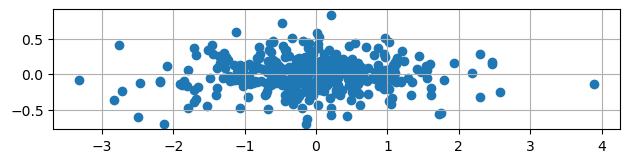

In [155]:
# Plotting for 1D inputs

plt.scatter(X * X_SCALING_FACTOR, Y * Y_SCALING_FACTOR)
plt.grid(True)
plt.tight_layout()
plt.gca().set_aspect('equal')
plt.show()

## What if we tried classifying the direction of the last 20 minutes?

In [156]:
first_x_min = 60 # minutes
last_x_min = 20 # minutes
X = []
Y = []

for key, date in enumerate(trading_days):
    if key == 0:
        pass # Skip the first day
    else:
        today_df = market_df[market_df.index.date == date]
        yesterday_df = market_df[market_df.index.date == trading_days[key-1]]

        last_x_min_price = today_df.iloc[-last_x_min]['average']
        closing_price = today_df.iloc[-1]['average']
        percent_change = (last_x_min_price -  closing_price) / last_x_min_price * 100
        if percent_change > 0:
            Y.append(1)
        else:
            Y.append(0)

        yesterday_close = yesterday_df.iloc[-1]['average']
        today_open = today_df.iloc[0]['average']
        gap_ppc = (today_open - yesterday_close) / today_open * 100

        first_x_min_ppc = today_df['ppc_from_open'].values.tolist()[first_x_min]
        
        X.append([gap_ppc + first_x_min_ppc])

X_SCALING_FACTOR = np.abs(np.max(X))
X = X / X_SCALING_FACTOR

## Testing Metric on Logistic Regression

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state = 1)

model = LogisticRegression(solver='liblinear')
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

print(y_test[0:10])
print(model.predict(x_test[0:10]))

print("\nError")
print(mean_absolute_error(y_test, model.predict(x_test)))

0.5109717868338558
0.475
[1, 1, 0, 0, 0, 1, 1, 0, 1, 1]
[0 0 0 0 0 0 0 0 0 0]

Error
0.525


## Bulk Feature Extraction

In [ ]:
# List of potential features
# [gap_ppc, 
# first_{60, 120, 180, 240, 300, 360}_min_ppc, 
# last_{5, 15, 30, 60, 120, 180}_min_ppc_before_roi,
# volume up to that point in the day,
# std_deviation (aross data before last x minutes)
# maximum_drawdown (np.max - np.min),
# integral of data - SMA 12]